## Chapter 3: Digging Into Linear Regression

### CREDIT CARD SPEND PREDICTION / KEY DRIVERS

### Table Of Contents
1. [Introduction](#introduction)
2. [Data Import](#dataimport)
    1. [Dataset Description](#Datasetdescription1)
    2. [Data Cleaning](#cleaning)
3. [EDA](#EDA)
    1. [Missing Value Treatment](#missing)
    2. [Outlier Analysis](#outlier)
    3. [Covariance And Correlation](#correlation)
    4. [Checking On Linearity Assumptions](#linearity)
4. [Model Training](#model)
5. [Optimization Algorithm/Grid Search](#grid)
6.  [Mlflow Introduction](#MLFlow)
    1. [Installation](#install)
    2. [Experimentation Tracking](#tracking)
7. [Regularization](#Regularization)
   1. [Ridge Regression](#ridge)
   2. [Lasso Regression](#lasso)
   3. [Elastic-Net Regression](#EN)


### Business Problem:
A global banks would like to understand what are the factors driving credit card spend. The bank wants to use these insights to determine credit limit. In order to solve the problem, the bank conducted survey of 5000 customers and collected data. The objective of this case study is to understand what's driving the total spend (Primary Card + Secondary card) of a customer. Identifying the given factors, predict credit limit for the new applicants.

### Import all necessary Libraries <a name="introduction"></a>

In [ ]:
#command to install any library directly through jupyter notebook
#import sys
#!{sys.executable} -m pip install -U mlflow==2.2.2

In [1]:
import pandas as pd
import numpy as np

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
from sklearn.preprocessing import LabelEncoder
import datetime
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix,f1_score,average_precision_score
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost
import itertools
#for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#for MLops
import mlflow
import mlflow.sklearn
#for supressing unwanted warning message
import warnings
warnings.filterwarnings("ignore")

In [2]:
print("Numpy: {}".format(np.__version__))
print("Pandas: {}".format(pd.__version__))
print("seaborn: {}".format(sns.__version__))
print("Scikit-Learn: {}".format(sklearn.__version__))
print("MLFlow: {}".format(mlflow.__version__))

Numpy: 1.23.5
Pandas: 1.5.3
seaborn: 0.12.2
Scikit-Learn: 1.2.1
MLFlow: 2.2.2


In [3]:
#Importing dataset as "data"
data=pd.read_excel("./Data Set.xlsx")
#Using head(), you can see first 5 rows
data.head()

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,3964-QJWTRG-NPN,1,2.0,1,20,2,September,15,3,1,...,0,0,0,1,1,0,0,0,1,0
1,0648-AIPJSP-UVM,5,5.0,0,22,2,May,17,4,2,...,1,1,1,1,1,1,1,0,0,0
2,5195-TLUDJE-HVO,3,4.0,1,67,6,June,14,2,2,...,1,0,0,0,0,0,1,0,0,0
3,4459-VLPQUH-3OL,4,3.0,0,23,2,May,16,3,2,...,1,0,1,1,1,0,1,1,0,0
4,8158-SMTQFB-CNO,2,2.0,0,26,3,July,16,3,2,...,1,0,1,0,1,0,0,0,1,0


In [4]:
#Change default display. These will help you to see all records as well as columns in the data set
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
#By directly calling data set by name, will show you first and last 5 rows together
data

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,union,employ,empcat,retire,income,lninc,inccat,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,default,jobsat,marital,spoused,spousedcat,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,homeown,hometype,address,addresscat,cars,carown,cartype,carvalue,carcatvalue,carbought,carbuy,commute,commutecat,commutetime,commutecar,commutemotorcycle,commutecarpool,commutebus,commuterail,commutepublic,commutebike,commutewalk,commutenonmotor,telecommute,reason,polview,polparty,polcontrib,vote,card,cardtype,cardbenefit,cardfee,cardtenure,cardtenurecat,card2,card2type,card2benefit,card2fee,card2tenure,card2tenurecat,cardspent,card2spent,active,bfast,tenure,churn,longmon,lnlongmon,longten,lnlongten,tollfree,tollmon,lntollmon,tollten,lntollten,equip,equipmon,lnequipmon,equipten,lnequipten,callcard,cardmon,lncardmon,cardten,lncardten,wireless,wiremon,lnwiremon,wireten,lnwireten,multline,voice,pager,internet,callid,callwait,forward,confer,ebill,owntv,hourstv,ownvcr,owndvd,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,3964-QJWTRG-NPN,1,2.0,1,20,2,September,15,3,1,1,0,1,0,31,3.433987,2,11.1,1.200909,0.183079,2.240091,0.806516,1,1,0,-1,-1,3,0,0,0,0,0,0,0,0,0,2,0,1,2,1,0,14.3,1,0,0,8,4,22.0,0,1,1,0,0,0,0,1,0,0,9,6,1,0,1,3,1,1,0,2,2,5,3,1,0,3,2,81.66,67.80,0,3,5,1,6.50,1.871802,34.40,3.538057,1,29.0,3.367296,161.05,5.081715,1,29.50,3.384390,126.10,4.837075,1,14.25,2.656757,60.0,4.094345,0,0.00,NaN,0.00,NaN,1,1,1,0,0,1,1,1,0,1,13,1,1,0,0,0,1,1,0,0,0,1,0
1,0648-AIPJSP-UVM,5,5.0,0,22,2,May,17,4,2,0,0,1,0,15,2.708050,1,18.6,1.222020,0.200505,1.567980,0.449788,1,1,0,-1,-1,2,6,0,0,0,0,0,0,6,1,3,2,1,2,1,1,6.8,1,0,0,1,1,29.0,1,0,0,1,0,0,1,0,1,1,9,4,1,0,0,2,4,1,0,4,2,4,1,3,0,4,2,42.60,34.94,1,1,39,0,8.90,2.186051,330.60,5.800909,0,0.0,NaN,0.00,NaN,1,54.85,4.004602,1975.00,7.588324,1,16.00,2.772589,610.0,6.413459,1,45.65,3.821004,1683.55,7.428660,1,1,1,4,1,0,1,0,1,1,18,1,1,1,1,1,1,1,1,1,0,0,0
2,5195-TLUDJE-HVO,3,4.0,1,67,6,June,14,2,2,0,16,5,0,35,3.555348,2,9.9,0.928620,-0.074056,2.536380,0.930738,0,4,1,13,2,3,3,2,1,0,0,0,0,0,1,1,30,5,3,1,1,18.8,1,0,1,4,3,24.0,1,0,1,1,1,0,0,0,0,0,2,5,1,0,0,2,1,4,0,35,5,4,1,3,0,25,5,184.22,175.75,0,3,65,0,28.40,3.346389,1858.35,7.527444,0,0.0,NaN,0.00,NaN,0,0.00,NaN,0.00,NaN,1,23.00,3.135494,1410.0,7.251345,0,0.00,NaN,0.00,NaN,1,0,0,0,0,0,0,0,0,1,21,1,1,1,0,0,0,0,0,1,0,0,0
3,4459-VLPQUH-3OL,4,3.0,0,23,2,May,16,3,2,0,0,1,0,20,2.995732,1,5.7,0.022800,-3.780995,1.117200,0.110826,1,2,1,18,4,5,0,0,0,0,0,0,0,0,1,3,3,2,3,1,1,8.7,1,0,1,1,1,38.0,1,0,0,0,0,0,0,0,0,0,9,3,0,0,0,2,1,4,0,5,2,3,2,4,0,5,2,340.99,18.42,1,1,36,0,6.00,1.791759,199.45,5.295564,0,0.0,NaN,0.00,NaN,0,0.00,NaN,0.00,NaN,1,21.00,3.044522,685.0,6.529419,0,0.00,NaN,0.00,NaN,1,0,0,2,0,0,0,0,1,1,26,1,1,1,0,1,1,1,0,1,1,0,0
4,8158-SMTQFB-CNO,2,2.0,0,26,3,July,16,3,2,0,1,1,0,23,3.135494,1,1.7,0.214659,-1.538705,0.176341,-1.735336,0,1,1,13,2,4,0,0,0,0,0,0,0,0,0,2,3,2,1,0,1,10.6,1,0,1,6,3,32.0,0,0,0,0,0,1,0,1,0,0,9,4,0,0,0,4,2,1,0,8,3,1,3,2,0,9,3,255.10,252.73,1,3,21,0,3.05,1.115142,74.10,4.305416,1,16.5,2.803360,387.70,5.960232,0,0.00,NaN,0.00,NaN,1,17.25,2.847812,360.0,5.886104,1,19.05,2.947067,410.80,6.018106,0,1,0,3,1,1,1,1,0,1,27,1,1,1,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,3675-GZFGOT-QJN,2,2.0,0,68,6,January,10,1,1,0,24,5,0,196,5.278115,5,8.0,7.934080,2.071167,7.745920,2.047166,0,1,0,-1,-1,1,4,4,0,0,0,0,0,0,1,1,24,4,1,1,0,6

### Dataset Description <a class="anchor" id="Datasetdescription1"></a>

In [5]:
#First we check Total number of records in data
print("Number of Records:", data.shape[0])
#Total number of variables in data
print("Number of Variable:", data.shape[1])
print(data.info())

Number of Records: 5000
Number of Variable: 130
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 130 entries, custid to response_03
dtypes: float64(31), int64(97), object(2)
memory usage: 5.0+ MB
None


### Initial Data Cleaning <a name="cleaning"></a>

In [6]:
#let's drop duplicate records, if any
data.drop_duplicates(inplace=True)

In [7]:
#lots of variables, so better first check missing values
#Counting the number of NULL values
data.isnull().sum().sort_values(ascending=False).head(10)

lnwiremon     3656
lnwireten     3656
lnequipmon    3296
lnequipten    3296
lntollten     2622
lntollmon     2622
lncardten     1422
lncardmon     1419
lnlongten        3
longten          3
dtype: int64

In [8]:
#check in percentage 
(data.isnull().sum()/len(data)*100).sort_values(ascending=False)

lnwiremon            73.12
lnwireten            73.12
lnequipmon           65.92
lnequipten           65.92
lntollten            52.44
lntollmon            52.44
lncardten            28.44
lncardmon            28.38
lnlongten             0.06
longten               0.06
cardten               0.04
townsize              0.04
commutetime           0.04
lnothdebt             0.02
lncreddebt            0.02
tollfree              0.00
tollmon               0.00
equip                 0.00
equipmon              0.00
tollten               0.00
lnlongmon             0.00
longmon               0.00
churn                 0.00
tenure                0.00
bfast                 0.00
active                0.00
card2spent            0.00
cardspent             0.00
card2tenurecat        0.00
card2tenure           0.00
card2fee              0.00
card2benefit          0.00
card2type             0.00
card2                 0.00
cardtenurecat         0.00
cardtenure            0.00
equipten              0.00
c

In [9]:
#Removing columns which containing major percentage atleast 50% of values missing
data.drop(['lnwiremon','lnwireten','lnequipmon','lnequipten','lntollmon','lntollten'],axis=1,inplace=True)

In [10]:
#customer id is unique identifier, so it will not add any value in our analysis. We can drop it or use it as index
data.index=data.custid
data.head(2)

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,union,employ,empcat,retire,income,lninc,inccat,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,default,jobsat,marital,spoused,spousedcat,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,homeown,hometype,address,addresscat,cars,carown,cartype,carvalue,carcatvalue,carbought,carbuy,commute,commutecat,commutetime,commutecar,commutemotorcycle,commutecarpool,commutebus,commuterail,commutepublic,commutebike,commutewalk,commutenonmotor,telecommute,reason,polview,polparty,polcontrib,vote,card,cardtype,cardbenefit,cardfee,cardtenure,cardtenurecat,card2,card2type,card2benefit,card2fee,card2tenure,card2tenurecat,cardspent,card2spent,active,bfast,tenure,churn,longmon,lnlongmon,longten,lnlongten,tollfree,tollmon,tollten,equip,equipmon,equipten,callcard,cardmon,lncardmon,cardten,lncardten,wireless,wiremon,wireten,multline,voice,pager,internet,callid,callwait,forward,confer,ebill,owntv,hourstv,ownvcr,owndvd,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
custid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3964-QJWTRG-NPN,3964-QJWTRG-NPN,1,2.0,1,20,2,September,15,3,1,1,0,1,0,31,3.433987,2,11.1,1.200909,0.183079,2.240091,0.806516,1,1,0,-1,-1,3,0,0,0,0,0,0,0,0,0,2,0,1,2,1,0,14.3,1,0,0,8,4,22.0,0,1,1,0,0,0,0,1,0,0,9,6,1,0,1,3,1,1,0,2,2,5,3,1,0,3,2,81.66,67.80,0,3,5,1,6.5,1.871802,34.4,3.538057,1,29.0,161.05,1,29.50,126.1,1,14.25,2.656757,60.0,4.094345,0,0.00,0.00,1,1,1,0,0,1,1,1,0,1,13,1,1,0,0,0,1,1,0,0,0,1,0
0648-AIPJSP-UVM,0648-AIPJSP-UVM,5,5.0,0,22,2,May,17,4,2,0,0,1,0,15,2.708050,1,18.6,1.222020,0.200505,1.567980,0.449788,1,1,0,-1,-1,2,6,0,0,0,0,0,0,6,1,3,2,1,2,1,1,6.8,1,0,0,1,1,29.0,1,0,0,1,0,0,1,0,1,1,9,4,1,0,0,2,4,1,0,4,2,4,1,3,0,4,2,42.60,34.94,1,1,39,0,8.9,2.186051,330.6,5.800909,0,0.0,0.00,1,54.85,1975.0,1,16.00,2.772589,610.0,6.413459,1,45.65,1683.55,1,1,1,4,1,0,1,0,1,1,18,1,1,1,1,1,1,1,1,1,0,0,0


In [11]:
#now drop existing cust id from data
data.drop(columns={'custid'},axis=1,inplace=True)

In [12]:
#check data type for each variable
data.dtypes

region                 int64
townsize             float64
gender                 int64
age                    int64
agecat                 int64
birthmonth            object
ed                     int64
edcat                  int64
jobcat                 int64
union                  int64
employ                 int64
empcat                 int64
retire                 int64
income                 int64
lninc                float64
inccat                 int64
debtinc              float64
creddebt             float64
lncreddebt           float64
othdebt              float64
lnothdebt            float64
default                int64
jobsat                 int64
marital                int64
spoused                int64
spousedcat             int64
reside                 int64
pets                   int64
pets_cats              int64
pets_dogs              int64
pets_birds             int64
pets_reptiles          int64
pets_small             int64
pets_saltfish          int64
pets_freshfish

### Creating All Categorical Variables List

In [13]:
#we can see lots of categorical columns are read as numeric, first correct it
categorical_var =['region','townsize','gender','agecat','birthmonth','edcat','jobcat','union',
'employ','empcat','retire','inccat','default','jobsat','marital','spousedcat',
'homeown','hometype','address','addresscat','cars','carown','cartype',
'carcatvalue','carbought','carbuy','commute','commutecat','commutecar','commutemotorcycle',
'commutecarpool','commutebus','commuterail','commutepublic','commutebike','commutewalk',
'commutenonmotor','telecommute','reason','polview','polparty','polcontrib','vote','card',
'cardtype','cardbenefit','cardfee','cardtenure','cardtenurecat','card2','card2type',
'card2benefit','card2fee','card2tenure','card2tenurecat','active','bfast','churn','tollfree',
'equip','callcard','wireless','multline','voice','pager','internet','callid','callwait','forward',
'confer','ebill','owntv','ownvcr','owndvd','owncd','ownpda','ownpc','ownipod','owngame','ownfax','news',
'response_01','response_02','response_03']

In [14]:
data[categorical_var]=data[categorical_var].astype(object)

In [15]:
data.dtypes

region                object
townsize              object
gender                object
age                    int64
agecat                object
birthmonth            object
ed                     int64
edcat                 object
jobcat                object
union                 object
employ                object
empcat                object
retire                object
income                 int64
lninc                float64
inccat                object
debtinc              float64
creddebt             float64
lncreddebt           float64
othdebt              float64
lnothdebt            float64
default               object
jobsat                object
marital               object
spoused                int64
spousedcat            object
reside                 int64
pets                   int64
pets_cats              int64
pets_dogs              int64
pets_birds             int64
pets_reptiles          int64
pets_small             int64
pets_saltfish          int64
pets_freshfish

In [16]:
#rest variables are numeric
numerical_var=[]
for i in data.columns:
    if i not in categorical_var:
        numerical_var.append(i)
print(numerical_var)

['age', 'ed', 'income', 'lninc', 'debtinc', 'creddebt', 'lncreddebt', 'othdebt', 'lnothdebt', 'spoused', 'reside', 'pets', 'pets_cats', 'pets_dogs', 'pets_birds', 'pets_reptiles', 'pets_small', 'pets_saltfish', 'pets_freshfish', 'carvalue', 'commutetime', 'cardspent', 'card2spent', 'tenure', 'longmon', 'lnlongmon', 'longten', 'lnlongten', 'tollmon', 'tollten', 'equipmon', 'equipten', 'cardmon', 'lncardmon', 'cardten', 'lncardten', 'wiremon', 'wireten', 'hourstv']


In [17]:
print ('Number of numerical variables   :-  {}'.format(len(numerical_var)))
print ('Number of categorical variables :-  {}'.format(len(categorical_var)))

Number of numerical variables   :-  39
Number of categorical variables :-  84


### EDA <a class="anchor" id="EDA"></a>

In [18]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,5000.0,47.025600,17.770338,18.000000,31.000000,47.000000,62.000000,79.000000
ed,5000.0,14.543000,3.281083,6.000000,12.000000,14.000000,17.000000,23.000000
income,5000.0,54.759600,55.377511,9.000000,24.000000,38.000000,67.000000,1073.000000
lninc,5000.0,3.699909,0.747072,2.197225,3.178054,3.637586,4.204693,6.978214
debtinc,5000.0,9.954160,6.399783,0.000000,5.100000,8.800000,13.600000,43.100000
creddebt,5000.0,1.857326,3.415732,0.000000,0.385520,0.926437,2.063820,109.072596
lncreddebt,4999.0,-0.130454,1.273058,-6.597334,-0.952685,-0.076106,0.724665,4.692014
othdebt,5000.0,3.654460,5.395172,0.000000,0.980301,2.098540,4.314780,141.459150
lnothdebt,4999.0,0.696915,1.128578,-4.092107,-0.018987,0.741537,1.462053,4.952011
spoused,5000.0,6.112800,7.743518,-1.000000,-1.000000,-1.000000,14.000000,24.000000


In [19]:
##let's see our data with numeric variable only
data_num=data.drop(columns=categorical_var,axis=1)
data_num.head()

,age,ed,income,lninc,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,spoused,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,carvalue,commutetime,cardspent,card2spent,tenure,longmon,lnlongmon,longten,lnlongten,tollmon,tollten,equipmon,equipten,cardmon,lncardmon,cardten,lncardten,wiremon,wireten,hourstv
custid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3964-QJWTRG-NPN,20,15,31,3.433987,11.1,1.200909,0.183079,2.240091,0.806516,-1,3,0,0,0,0,0,0,0,0,14.3,22.0,81.66,67.80,5,6.50,1.871802,34.40,3.538057,29.0,161.05,29.50,126.1,14.25,2.656757,60.0,4.094345,0.00,0.00,13
0648-AIPJSP-UVM,22,17,15,2.708050,18.6,1.222020,0.200505,1.567980,0.449788,-1,2,6,0,0,0,0,0,0,6,6.8,29.0,42.60,34.94,39,8.90,2.186051,330.60,5.800909,0.0,0.00,54.85,1975.0,16.00,2.772589,610.0,6.413459,45.65,1683.55,18
5195-TLUDJE-HVO,67,14,35,3.555348,9.9,0.928620,-0.074056,2.536380,0.930738,13,3,3,2,1,0,0,0,0,0,18.8,24.0,184.22,175.75,65,28.40,3.346389,1858.35,7.527444,0.0,0.00,0.00,0.0,23.00,3.135494,1410.0,7.251345,0.00,0.00,21
4459-VLPQUH-3OL,23,16,20,2.995732,5.7,0.022800,-3.780995,1.117200,0.110826,18,5,0,0,0,0,0,0,0,0,8.7,38.0,340.99,18.42,36,6.00,1.791759,199.45,5.295564,0.0,0.00,0.00,0.0,21.00,3.044522,685.0,6.529419,0.00,0.00,26
8158-SMTQFB-CNO,26,16,23,3.135494,1.7,0.214659,-1.538705,0.176341,-1.735336,13,4,0,0,0,0,0,0,0,0,10.6,32.0,255.10,252.73,21,3.05,1.115142,74.10,4.305416,16.5,387.70,0.00,0.0,17.25,2.847812,360.0,5.886104,19.05,410.80,27


In [20]:
##let's see our data with categorical variable only
data.loc[:, categorical_var].head(3)

,region,townsize,gender,agecat,birthmonth,edcat,jobcat,union,employ,empcat,retire,inccat,default,jobsat,marital,spousedcat,homeown,hometype,address,addresscat,cars,carown,cartype,carcatvalue,carbought,carbuy,commute,commutecat,commutecar,commutemotorcycle,commutecarpool,commutebus,commuterail,commutepublic,commutebike,commutewalk,commutenonmotor,telecommute,reason,polview,polparty,polcontrib,vote,card,cardtype,cardbenefit,cardfee,cardtenure,cardtenurecat,card2,card2type,card2benefit,card2fee,card2tenure,card2tenurecat,active,bfast,churn,tollfree,equip,callcard,wireless,multline,voice,pager,internet,callid,callwait,forward,confer,ebill,owntv,ownvcr,owndvd,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
custid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3964-QJWTRG-NPN,1,2.0,1,2,September,3,1,1,0,1,0,2,1,1,0,-1,0,2,0,1,2,1,0,1,0,0,8,4,0,1,1,0,0,0,0,1,0,0,9,6,1,0,1,3,1,1,0,2,2,5,3,1,0,3,2,0,3,1,1,1,1,0,1,1,1,0,0,1,1,1,0,1,1,1,0,0,0,1,1,0,0,0,1,0
0648-AIPJSP-UVM,5,5.0,0,2,May,4,2,0,0,1,0,1,1,1,0,-1,1,3,2,1,2,1,1,1,0,0,1,1,1,0,0,1,0,0,1,0,1,1,9,4,1,0,0,2,4,1,0,4,2,4,1,3,0,4,2,1,1,0,0,1,1,1,1,1,1,4,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0
5195-TLUDJE-HVO,3,4.0,1,6,June,2,2,0,16,5,0,2,0,4,1,2,1,1,30,5,3,1,1,1,0,1,4,3,1,0,1,1,1,0,0,0,0,0,2,5,1,0,0,2,1,4,0,35,5,4,1,3,0,25,5,0,3,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,0,0,0


### Missing Value Treatment <a class="anchor" id="missing"></a>

In [21]:
#Counting the number of NULL values
data.isnull().sum().sort_values(ascending=False).head(10)

lncardten      1422
lncardmon      1419
lnlongten         3
longten           3
townsize          2
commutetime       2
cardten           2
lnothdebt         1
lncreddebt        1
longmon           0
dtype: int64

In [22]:
#impute with mean for higher missing percentage variable
A = ['lncardten','lncardmon']
data[A] = data[A].fillna(data[A].mean())

In [23]:
#let's verify it
data.isnull().sum().sort_values(ascending=False).head(10)

lnlongten      3
longten        3
townsize       2
commutetime    2
cardten        2
lnothdebt      1
lncreddebt     1
region         0
lnlongmon      0
churn          0
dtype: int64

In [24]:
#impute categorical variable
data.townsize.fillna(data.townsize.mode(), inplace=True)

In [25]:
#for rest of cases, we can impute it with same strategy depending on data type- impute with mean, median or mode
#here, for simplicity, we will drop cases with missing values as they are very few
data = data.dropna(how='any')

### Outlier Analysis <a class="anchor" id="outlier"></a>

<Axes: ylabel='Frequency'>

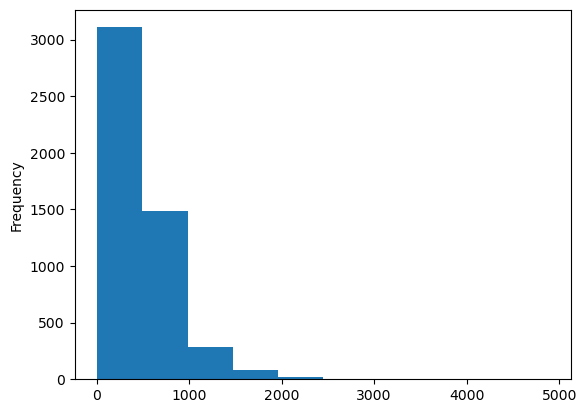

In [26]:
#Card Spent for 1 and 2 will be combined to get total spend. It will be our model dependent variable
data['total_spent']=data['cardspent']+data['card2spent']
data['total_spent'].plot(kind='hist')

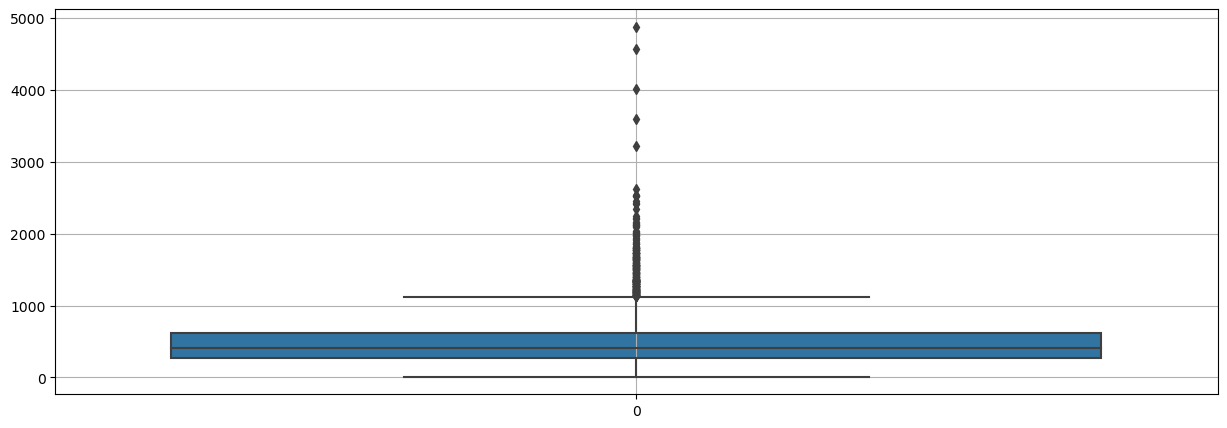

In [27]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data['total_spent'],ax=ax)
plt.grid()
plt.show()

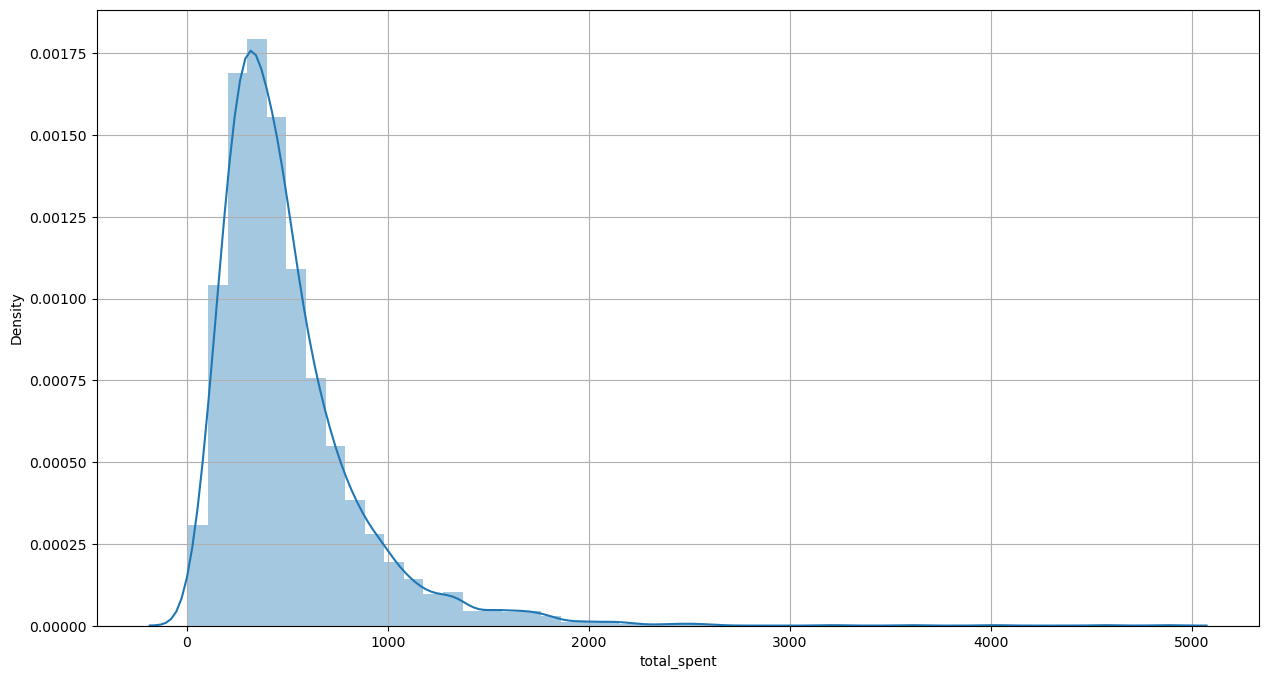

In [28]:
fig, ax = plt.subplots(figsize=(15,8))
sns.distplot(data['total_spent'],ax=ax)
plt.grid()
plt.show()

In [29]:
#not looks normal, let's transform to remove skewness into log n check
data['total_spent_ln']=np.log(data['total_spent'])

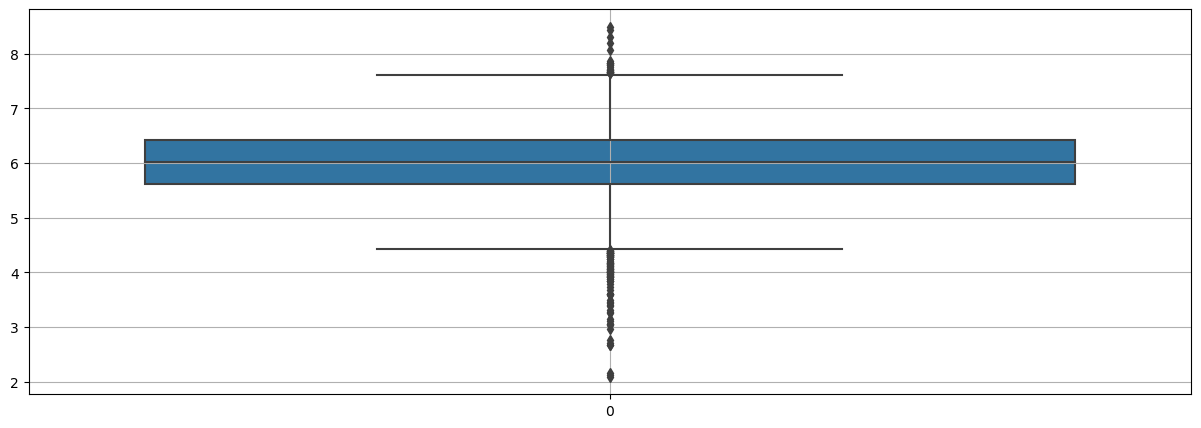

In [30]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data['total_spent_ln'],ax=ax)
plt.grid()
plt.show()

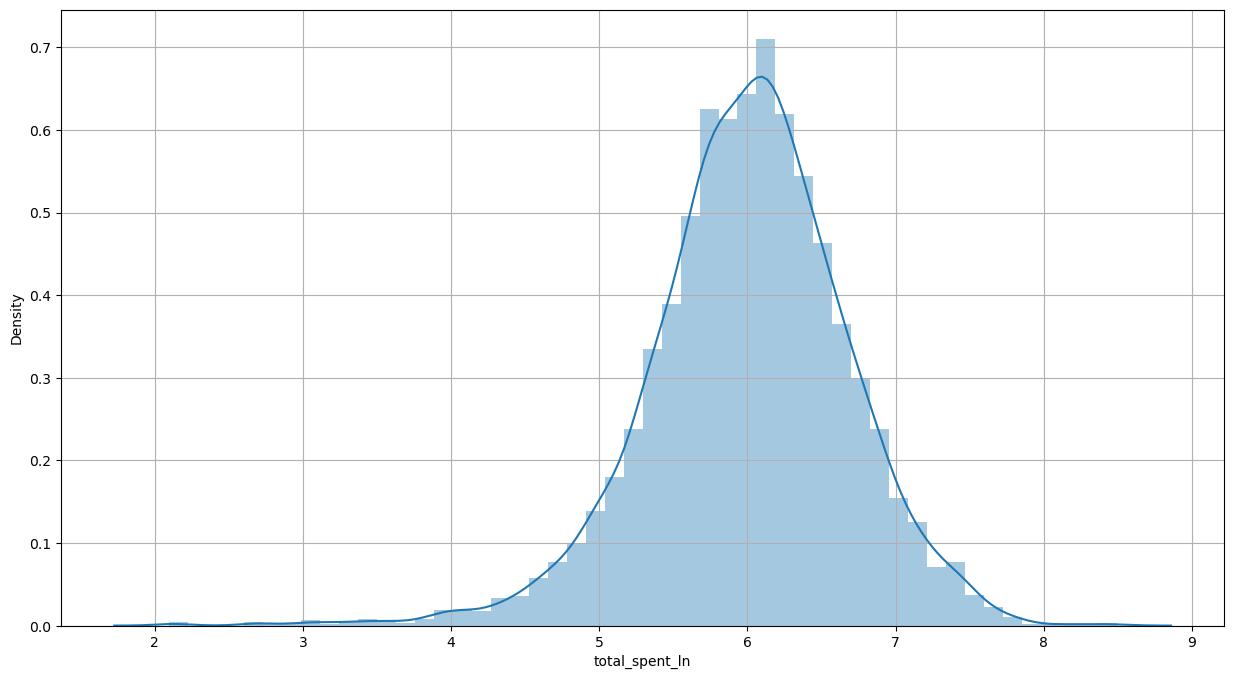

In [31]:
fig, ax = plt.subplots(figsize=(15,8))
sns.distplot(data['total_spent_ln'],ax=ax)
plt.grid()
plt.show()

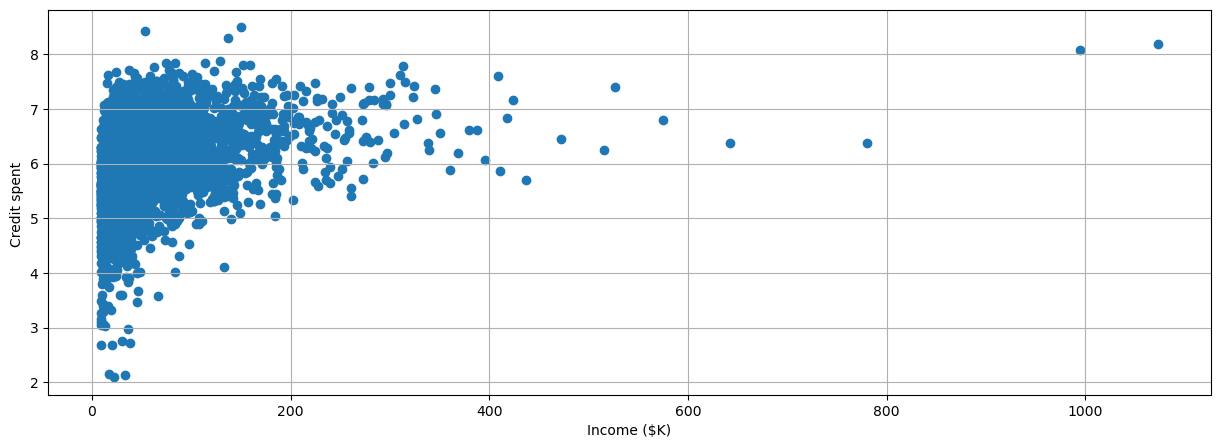

In [32]:
plt.subplots(figsize=(15,5))
plt.scatter(data['income'],data['total_spent_ln'])
plt.xlabel('Income ($K)')
plt.ylabel('Credit spent ')
plt.grid()
plt.show()

In [33]:
#append our new derived variable to numeric list
numerical_var.append('total_spent_ln')

In [34]:
data.drop(columns={'cardspent','card2spent','total_spent'},inplace=True)

In [35]:
print(len(numerical_var))
numerical_var = [x for x in numerical_var if x not in {'cardspent','card2spent','total_spent'}]
len(numerical_var)

40


38

In [36]:
#check numeric variable distribution
data[numerical_var].describe(percentiles=[.1,.25, .75,.9,.95,.99]).T.round(2)

,count,mean,std,min,10%,25%,50%,75%,90%,95%,99%,max
age,4994.0,47.04,17.76,18.00,23.00,31.00,47.00,62.00,72.00,76.00,79.00,79.00
ed,4994.0,14.54,3.28,6.00,10.00,12.00,14.00,17.00,19.00,20.00,21.00,23.00
income,4994.0,54.76,55.38,9.00,16.00,24.00,38.00,67.00,109.00,147.00,272.07,1073.00
lninc,4994.0,3.70,0.75,2.20,2.77,3.18,3.64,4.20,4.69,4.99,5.61,6.98
debtinc,4994.0,9.95,6.40,0.10,2.80,5.12,8.80,13.60,18.60,22.20,29.20,43.10
creddebt,4994.0,1.86,3.42,0.00,0.18,0.39,0.93,2.06,4.30,6.38,14.28,109.07
lncreddebt,4994.0,-0.13,1.27,-6.60,-1.74,-0.95,-0.08,0.72,1.46,1.85,2.66,4.69
othdebt,4994.0,3.66,5.40,0.02,0.46,0.98,2.10,4.31,8.06,11.83,24.08,141.46
lnothdebt,4994.0,0.70,1.13,-4.09,-0.78,-0.02,0.74,1.46,2.09,2.47,3.18,4.95
spoused,4994.0,6.11,7.75,-1.00,-1.00,-1.00,-1.00,14.00,16.00,18.00,20.00,24.00


In [37]:
#seems lots of outlier present. let's correct it by capping the extreame high or extream low value, so that it will not have impact on our model
data[numerical_var]=data[numerical_var].apply(lambda x: x.clip(lower = x.dropna().quantile(0.05), upper = x.quantile(0.99)))

In [38]:
data[numerical_var].describe(percentiles=[.1,.25,.99]).T.round(2)

,count,mean,std,min,10%,25%,50%,99%,max
age,4994.0,47.10,17.67,20.00,23.00,31.00,47.00,79.00,79.00
ed,4994.0,14.57,3.19,9.00,10.00,12.00,14.00,21.00,21.00
income,4994.0,53.76,46.44,13.00,16.00,24.00,38.00,272.00,272.07
lninc,4994.0,3.71,0.72,2.56,2.77,3.18,3.64,5.61,5.61
debtinc,4994.0,9.95,6.19,1.90,2.80,5.12,8.80,29.20,29.20
creddebt,4994.0,1.76,2.38,0.10,0.18,0.39,0.93,14.28,14.28
lncreddebt,4994.0,-0.10,1.18,-2.29,-1.74,-0.95,-0.08,2.66,2.66
othdebt,4994.0,3.53,4.22,0.29,0.46,0.98,2.10,24.06,24.08
lnothdebt,4994.0,0.72,1.06,-1.24,-0.78,-0.02,0.74,3.18,3.18
spoused,4994.0,6.10,7.71,-1.00,-1.00,-1.00,-1.00,20.00,20.00


In [39]:
#similarly check for categorical variables
data['inccat'].value_counts(dropna=False)

2    1797
1    1326
3     839
4     649
5     383
Name: inccat, dtype: int64

In [40]:
#there are too many categorical variable, better do it using some function
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(),x.nunique(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS','Unique', 'MODE', 'FREQ', 'PERCENT'])

In [41]:
data_cat_var=data.loc[:, categorical_var]
data_cat_var.apply(categorical_var_summary).T.round(1)

,N,NMISS,Unique,MODE,FREQ,PERCENT
region,4994.0,0.0,5.0,5.0,1025.0,20.52
townsize,4994.0,0.0,5.0,1.0,1436.0,28.75
gender,4994.0,0.0,2.0,1.0,2515.0,50.36
agecat,4994.0,0.0,5.0,4.0,1220.0,24.43
birthmonth,4994,0,12,September,458,9.17
edcat,4994.0,0.0,5.0,2.0,1564.0,31.32
jobcat,4994.0,0.0,6.0,2.0,1638.0,32.8
union,4994.0,0.0,2.0,0.0,4239.0,84.88
employ,4994.0,0.0,52.0,0.0,656.0,13.14
empcat,4994.0,0.0,5.0,2.0,1180.0,23.63


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4994 entries, 3964-QJWTRG-NPN to 8027-EXDZBF-OGR
Columns: 122 entries, region to total_spent_ln
dtypes: float64(25), int64(14), object(83)
memory usage: 4.8+ MB


In [ ]:
#we need to do eda for all input variable. better do it using some library like data_profiling, sweetviz etc
#below is example code. will show it in next chapter
#import ydata_profiling
# from ydata_profiling import ProfileReport
# data_report= ProfileReport(data, title="Pandas Profiling Report")
# data_report
#you can save it as well using below code
#data_report.to_file('credit_reportdata_report

### Covariance And Correlation <a class="anchor" id="correlation"></a>

In [43]:
data[numerical_var].cov().round(2)

,age,ed,income,lninc,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,spoused,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,carvalue,commutetime,tenure,longmon,lnlongmon,longten,lnlongten,tollmon,tollten,equipmon,equipten,cardmon,lncardmon,cardten,lncardten,wiremon,wireten,hourstv,total_spent_ln
age,312.39,-5.33,173.17,2.10,4.24,5.94,2.26,11.43,2.42,-0.54,-8.12,1.51,0.23,0.17,-0.13,0.04,0.01,-0.01,1.24,64.97,-5.69,242.79,95.45,6.87,7890.08,15.68,29.75,4249.59,-35.58,1407.76,73.89,1.18,6949.73,6.57,-8.99,1772.55,-0.49,0.15
ed,-5.33,10.16,27.74,0.48,0.24,0.93,0.50,1.83,0.53,2.78,0.09,0.32,0.02,0.06,0.02,-0.00,0.02,-0.00,0.19,10.72,-0.13,-6.85,-3.57,-0.22,-294.61,-0.41,0.95,-35.45,27.22,972.89,-1.77,-0.01,-215.40,-0.16,21.04,788.33,-0.28,0.19
income,173.17,27.74,2156.38,30.20,3.78,69.42,29.85,136.54,29.94,12.69,-4.67,1.26,0.04,0.79,0.05,-0.02,-0.19,-0.11,0.69,820.65,-5.70,249.21,104.05,7.49,8314.19,16.90,175.13,12123.49,97.02,6710.18,109.17,1.78,7837.66,6.67,189.16,10938.95,4.53,10.06
lninc,2.10,0.48,30.20,0.51,0.07,0.98,0.51,1.95,0.51,0.25,-0.06,0.02,0.00,0.01,0.00,0.00,0.00,-0.00,-0.00,12.29,-0.10,3.34,1.17,0.09,93.57,0.23,2.59,170.82,1.68,102.43,1.47,0.02,97.95,0.09,2.98,161.33,0.12,0.17
debtinc,4.24,0.24,3.78,0.07,38.36,6.82,4.03,13.76,4.09,-1.96,-0.23,-0.06,-0.00,-0.01,-0.04,0.03,0.03,0.02,-0.10,2.04,0.03,2.73,0.95,0.07,82.90,0.18,-0.64,39.55,-0.05,66.76,1.15,0.02,86.85,0.09,0.06,53.46,-0.35,0.06
creddebt,5.94,0.93,69.42,0.98,6.82,5.67,2.24,6.43,1.43,0.04,-0.17,-0.08,-0.01,0.02,-0.01,0.00,-0.00,0.00,-0.09,26.20,-0.17,8.01,3.40,0.24,273.24,0.54,5.08,372.56,2.74,217.45,3.49,0.05,244.85,0.20,5.10,315.15,0.12,0.34
lncreddebt,2.26,0.50,29.85,0.51,4.03,2.24,1.39,2.83,0.84,0.04,-0.08,-0.03,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.04,11.94,-0.20,3.28,1.17,0.09,95.21,0.22,2.01,147.02,1.69,109.95,1.25,0.01,88.25,0.08,2.62,150.75,0.04,0.18
othdebt,11.43,1.83,136.54,1.95,13.76,6.43,2.83,17.81,3.68,0.55,-0.31,0.16,0.03,0.03,-0.01,0.01,-0.01,0.00,0.09,53.58,-0.29,17.23,6.88,0.50,556.59,1.15,11.24,796.99,6.45,466.44,7.33,0.12,526.62,0.46,13.03,762.07,0.21,0.67
lnothdebt,2.42,0.53,29.94,0.51,4.09,1.43,0.84,3.68,1.11,0.05,-0.10,0.03,0.01,0.00,-0.00,0.00,0.01,0.00,-0.00,12.29,-0.09,3.53,1.20,0.10,98.12,0.24,2.45,170.60,1.65,104.47,1.46,0.02,100.08,0.10,2.97,164.22,0.10,0.18
spoused,-0.54,2.78,12.69,0.25,-1.96,0.04,0.04,0.55,0.05,59.46,6.42,-0.03,-0.01,-0.04,-0.08,0.00,0.01,0.01,0.10,4.99,-0.02,26.78,11.32,0.85,880.87,1.93,7.88,628.87,9.62,741.98,9.23,0.15,729.70,0.69,10.80,714.74,0.58,0.15


In [44]:
corr_mat = data[numerical_var].corr(method='pearson').round(2)
corr_mat

,age,ed,income,lninc,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,spoused,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,carvalue,commutetime,tenure,longmon,lnlongmon,longten,lnlongten,tollmon,tollten,equipmon,equipten,cardmon,lncardmon,cardten,lncardten,wiremon,wireten,hourstv,total_spent_ln
age,1.00,-0.09,0.21,0.17,0.04,0.14,0.11,0.15,0.13,-0.00,-0.34,0.03,0.02,0.01,-0.02,0.01,0.00,-0.00,0.02,0.17,-0.06,0.61,0.47,0.52,0.50,0.58,0.11,0.26,-0.11,0.09,0.30,0.15,0.46,0.45,-0.03,0.11,-0.01,0.01
ed,-0.09,1.00,0.19,0.21,0.01,0.12,0.13,0.14,0.16,0.11,0.02,0.03,0.01,0.03,0.01,-0.00,0.01,-0.01,0.02,0.16,-0.01,-0.10,-0.10,-0.09,-0.10,-0.08,0.02,-0.01,0.45,0.35,-0.04,-0.01,-0.08,-0.06,0.35,0.27,-0.02,0.10
income,0.21,0.19,1.00,0.91,0.01,0.63,0.54,0.70,0.61,0.04,-0.07,0.01,0.00,0.02,0.00,-0.00,-0.01,-0.01,0.00,0.84,-0.02,0.24,0.19,0.22,0.20,0.24,0.24,0.29,0.11,0.16,0.17,0.09,0.20,0.17,0.21,0.25,0.02,0.36
lninc,0.17,0.21,0.91,1.00,0.02,0.57,0.60,0.64,0.68,0.05,-0.07,0.01,0.01,0.02,0.01,0.00,0.01,-0.01,-0.00,0.81,-0.03,0.21,0.14,0.18,0.15,0.21,0.23,0.26,0.12,0.16,0.15,0.07,0.16,0.15,0.22,0.24,0.04,0.40
debtinc,0.04,0.01,0.01,0.02,1.00,0.46,0.55,0.53,0.63,-0.04,-0.03,-0.00,-0.00,-0.00,-0.01,0.02,0.01,0.02,-0.01,0.02,0.00,0.02,0.01,0.01,0.01,0.02,-0.01,0.01,-0.00,0.01,0.01,0.01,0.02,0.02,0.00,0.01,-0.01,0.02
creddebt,0.14,0.12,0.63,0.57,0.46,1.00,0.80,0.64,0.57,0.00,-0.05,-0.01,-0.01,0.01,-0.00,0.01,-0.00,0.01,-0.01,0.52,-0.01,0.15,0.12,0.14,0.13,0.15,0.13,0.17,0.06,0.10,0.10,0.05,0.12,0.10,0.11,0.14,0.01,0.24
lncreddebt,0.11,0.13,0.54,0.60,0.55,0.80,1.00,0.57,0.68,0.00,-0.05,-0.01,-0.00,0.00,0.00,0.01,0.01,-0.00,-0.01,0.48,-0.03,0.12,0.09,0.10,0.09,0.12,0.11,0.14,0.08,0.11,0.07,0.03,0.09,0.08,0.12,0.14,0.01,0.26
othdebt,0.15,0.14,0.70,0.64,0.53,0.64,0.57,1.00,0.83,0.02,-0.05,0.01,0.01,0.01,-0.00,0.01,-0.00,0.00,0.01,0.60,-0.01,0.18,0.14,0.16,0.15,0.18,0.17,0.21,0.08,0.13,0.12,0.06,0.15,0.13,0.16,0.19,0.01,0.27
lnothdebt,0.13,0.16,0.61,0.68,0.63,0.57,0.68,0.83,1.00,0.01,-0.07,0.01,0.01,0.00,-0.00,0.01,0.02,0.01,-0.00,0.55,-0.02,0.15,0.10,0.12,0.10,0.15,0.15,0.18,0.08,0.11,0.10,0.05,0.11,0.11,0.15,0.17,0.02,0.28
spoused,-0.00,0.11,0.04,0.05,-0.04,0.00,0.00,0.02,0.01,1.00,0.61,-0.00,-0.00,-0.01,-0.02,0.00,0.00,0.01,0.00,0.03,-0.00,0.15,0.13,0.15,0.13,0.16,0.06,0.09,0.07,0.11,0.08,0.04,0.11,0.11,0.07,0.10,0.02,0.03


In [45]:
# Retain upper triangular values of correlation matrix and
# make Lower triangular values Null
upper_corr_mat = corr_mat.where(
    np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))

In [46]:
# Convert correlation matrix to 1-D Series and sort
unique_corr_pairs = upper_corr_mat.unstack().dropna()
sorted_mat = unique_corr_pairs.sort_values()
print(sorted_mat)

reside          age         -0.34
equipmon        age         -0.11
longten         ed          -0.10
longmon         ed          -0.10
tenure          reside      -0.10
                             ... 
pets_freshfish  pets         0.90
lninc           income       0.91
lnlongten       lnlongmon    0.93
                tenure       0.95
longten         longmon      0.98
Length: 703, dtype: float64


-addresscat is highly correlated with address (ρ = 0.9235209425) Rejected
-agecat is highly correlated with age (ρ = 0.9698787511) Rejected
-card2tenurecat is highly correlated with card2tenure (ρ = 0.9243911464) Rejected
-cardtenure is highly correlated with card2tenure (ρ = 0.9629752995) Rejected
-cardtenurecat is highly correlated with card2tenurecat (ρ = 0.9243052909) Rejected
-commutecat is highly correlated with commute (ρ = 0.981171323) Rejected
-edcat is highly correlated with ed (ρ = 0.9638959094) Rejected
-equipmon is highly correlated with equip (ρ = 0.9405054161) Rejected
-lninc is highly correlated with inccat (ρ = 0.9487921563) Rejected
-lnlongten is highly correlated with lnlongmon (ρ = 0.9217106724) Rejected
-longten is highly correlated with longmon (ρ = 0.9856982538) Rejected
-spoused is highly correlated with marital (ρ = 0.9557686636) Rejected
-spousedcat is highly correlated with spoused (ρ = 0.9840285958) Rejected
-tenure is highly correlated with lnlongten (ρ = 0.9268535788) Rejected

In [47]:
drop_col=['addresscat','agecat','card2tenurecat','cardtenurecat','cardtenure','commutecat','edcat','equipmon','inccat','lnlongten',
            'longten', 'spoused','spousedcat','tenure','tollmon','wiremon']
data.drop(drop_col,axis=1,inplace=True)

In [48]:
categorical_var = [x for x in categorical_var if x not in {'addresscat','agecat','card2tenurecat','cardtenurecat','cardtenure','commutecat','edcat','equipmon','inccat','lnlongten',
            'longten', 'spoused','spousedcat','tenure','tollmon','wiremon'}]

### Checking On Linearity Assumptions <a class="anchor" id="linearity"></a>

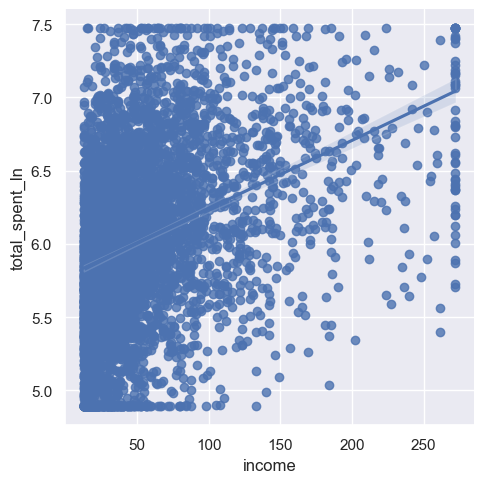

In [49]:
# Seaborn scatter plot with regression line. you can use scatter plot by using df.plot as well
#fig, ax = plt.subplots(figsize=(15,8))
sns.set(rc={'figure.figsize':(15,8)})
sns.lmplot(x='income', y='total_spent_ln', data=data)

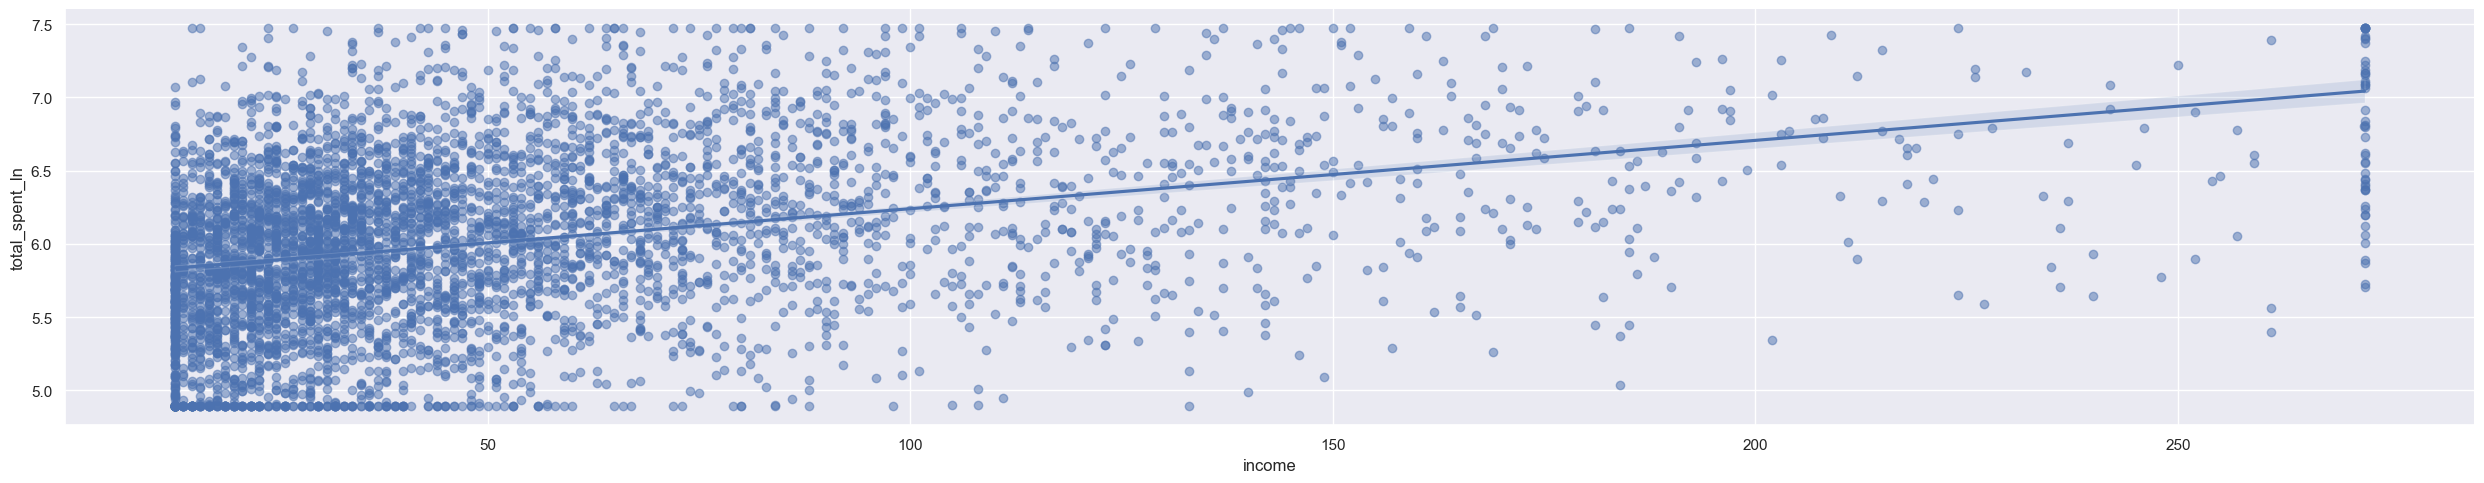

In [50]:
sns.lmplot(x="income",y="total_spent_ln",data=data,aspect=5,scatter_kws={'alpha':0.5})

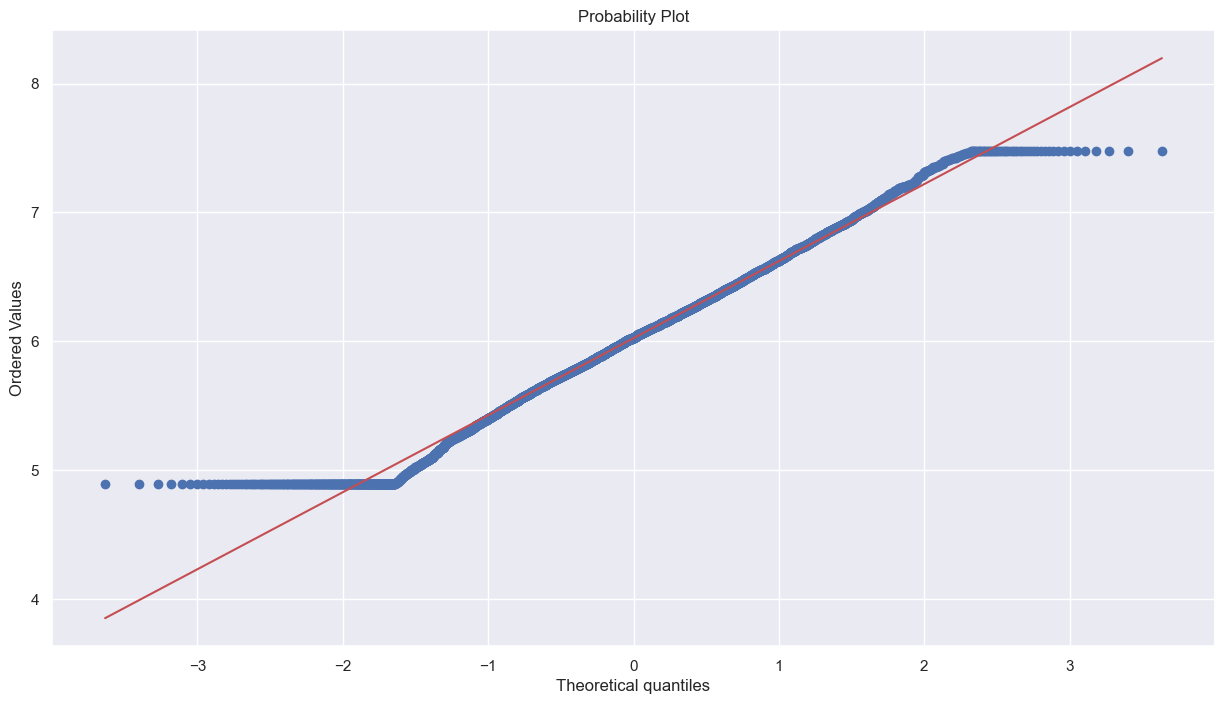

In [51]:
from scipy import stats
import pylab

stats.probplot(data.total_spent_ln, dist="norm", plot=pylab )
pylab.show()

### Model Training<a class="anchor" id="model"></a>

In [52]:
# We need to create a function for dummy creation for categorical columns
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname)
    col_dummies.drop(col_dummies.columns[0], axis = 1, inplace = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True)
    return df

In [53]:
df_cat=data[categorical_var]
cat_varlist=list(df_cat.columns)

In [54]:
for categorical_var in cat_varlist:
    data[categorical_var]=data[categorical_var].astype('category')
    data=create_dummies(data,categorical_var)

In [55]:
data.head(2)

,age,ed,income,lninc,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,carvalue,commutetime,longmon,lnlongmon,tollten,equipten,cardmon,lncardmon,cardten,lncardten,wireten,hourstv,total_spent_ln,region_2,region_3,region_4,region_5,townsize_2.0,townsize_3.0,townsize_4.0,townsize_5.0,gender_1,birthmonth_August,birthmonth_December,birthmonth_February,birthmonth_January,birthmonth_July,birthmonth_June,birthmonth_March,birthmonth_May,birthmonth_November,birthmonth_October,birthmonth_September,jobcat_2,jobcat_3,jobcat_4,jobcat_5,jobcat_6,union_1,employ_1,employ_2,employ_3,employ_4,employ_5,employ_6,employ_7,employ_8,employ_9,employ_10,employ_11,employ_12,employ_13,employ_14,employ_15,employ_16,employ_17,employ_18,employ_19,employ_20,employ_21,employ_22,employ_23,employ_24,employ_25,employ_26,employ_27,employ_28,employ_29,employ_30,employ_31,employ_32,employ_33,employ_34,employ_35,employ_36,employ_37,employ_38,employ_39,employ_40,employ_41,employ_42,employ_43,employ_44,employ_45,employ_46,employ_47,employ_48,employ_49,employ_51,employ_52,empcat_2,empcat_3,empcat_4,empcat_5,retire_1,default_1,jobsat_2,jobsat_3,jobsat_4,jobsat_5,marital_1,homeown_1,hometype_2,hometype_3,hometype_4,address_1,address_2,address_3,address_4,address_5,address_6,address_7,address_8,address_9,address_10,address_11,address_12,address_13,address_14,address_15,address_16,address_17,address_18,address_19,address_20,address_21,address_22,address_23,address_24,address_25,address_26,address_27,address_28,address_29,address_30,address_31,address_32,address_33,address_34,address_35,address_36,address_37,address_38,address_39,address_40,address_41,address_42,address_43,address_44,address_45,address_46,address_47,address_48,address_49,address_50,address_51,address_52,address_53,address_54,address_55,address_57,cars_1,cars_2,cars_3,cars_4,cars_5,cars_6,cars_7,cars_8,carown_0,carown_1,cartype_0,cartype_1,carcatvalue_1,carcatvalue_2,carcatvalue_3,carbought_0,carbought_1,carbuy_1,commute_2,commute_3,commute_4,commute_5,commute_6,commute_7,commute_8,commute_9,commute_10,commutecar_1,commutemotorcycle_1,commutecarpool_1,commutebus_1,commuterail_1,commutepublic_1,commutebike_1,commutewalk_1,commutenonmotor_1,telecommute_1,reason_2,reason_3,reason_4,reason_9,polview_2,polview_3,polview_4,polview_5,polview_6,polview_7,polparty_1,polcontrib_1,vote_1,card_2,card_3,card_4,card_5,cardtype_2,cardtype_3,cardtype_4,cardbenefit_2,cardbenefit_3,cardbenefit_4,cardfee_1,card2_2,card2_3,card2_4,card2_5,card2type_2,card2type_3,card2type_4,card2benefit_2,card2benefit_3,card2benefit_4,card2fee_1,card2tenure_1,card2tenure_2,card2tenure_3,card2tenure_4,card2tenure_5,card2tenure_6,card2tenure_7,card2tenure_8,card2tenure_9,card2tenure_10,card2tenure_11,card2tenure_12,card2tenure_13,card2tenure_14,card2tenure_15,card2tenure_16,card2tenure_17,card2tenure_18,card2tenure_19,card2tenure_20,card2tenure_21,card2tenure_22,card2tenure_23,card2tenure_24,card2tenure_25,card2tenure_26,card2tenure_27,card2tenure_28,card2tenure_29,card2tenure_30,active_1,bfast_2,bfast_3,churn_1,tollfree_1,equip_1,callcard_1,wireless_1,multline_1,voice_1,pager_1,internet_1,internet_2,internet_3,internet_4,callid_1,callwait_1,forward_1,confer_1,ebill_1,owntv_1,ownvcr_1,owndvd_1,owncd_1,ownpda_1,ownpc_1,ownipod_1,owngame_1,ownfax_1,news_1,response_01_1,response_02_1,response_03_1
custid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3964-QJWTRG-NPN,20,15,31.0,3.433987,11.1,1.200909,0.183079,2.240091,0.806516,3,0,0,0,0,0,0,0,0,14.3,22.0,6.5,1.871802,161.05,126.1,14.25,2.656757,60.0,4.499810,0.00,13,5.007029,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0

In [56]:
data.shape

(4994, 314)

### Multivariate Modelling

*After EDA, we know which variables seem to have the most impact on Balance, we can begin fitting models and seeing which variables we can select.

Since we have a choice of too many variables, from which we will choose few variable based on business logic to see a base model. You can experiment here by choosing all/few different variables

We use the Ordinary Least Square algorithm and we start by fitting a model which includes our selected variables.

In [57]:
model_base = smf.ols('total_spent_ln ~ age + income + lninc + carvalue + lnothdebt + carcatvalue_3 + othdebt + creddebt + retire_1', data = data).fit()
model_base.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         total_spent_ln   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     110.0
Date:                Mon, 01 May 2023   Prob (F-statistic):          9.38e-189
Time:                        20:52:44   Log-Likelihood:                -4089.8
No. Observations:                4994   AIC:                             8200.
Df Residuals:                    4984   BIC:                             8265.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.7880      0.099     48.565      0.000       4.595       4.981
age              -0.0020      0.001     -3.257      0.001      -0.003      -0.001
income        -2.674e-05      0.001     -0.052      0.958      -0.001       0.001
lninc             0.3651      0.033     10.910      0.000       0.299       0.431
carvalue         -0.0018      0.001     -2.118      0.034      -0.003      -0.000
lnothdebt         0.0041      0.015      0.271      0.786      -0.025       0.034
carcatvalue_3     0.0395      0.038      1.048      0.295      -0.034       0.113
othdebt           0.0012      0.004      0.314      0.754      -0.006       0.009
creddebt          0.0027      0.005      0.604      0.546      -0.006       0.012
retire_1          0.0167      0.035      0.481      0.631      -0.051       0.085
==============================================================================
Omnibus:                       30.626   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.648
Skew:                          -0.003   Prob(JB):                     1.99e-05
Kurtosis:                       2.678   Cond. No.                     1.18e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.18e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

*Income is negatively related to total spent which could be interpreted in the sense that the higher the Income, the lower the spends. Seems its not intutive, so we will drop it and use it's transformed value.
Surprisingly, Income do not have a significant impact on the total spend. Other variables with no impact are Other debt, creddebt, carcatvalue_3 and retire_1.

We fit the same model on our reduced dataset using significant variables only

In [58]:
model_1 = smf.ols('total_spent_ln ~ age  + lninc + carvalue', data = data).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         total_spent_ln   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     329.2
Date:                Mon, 01 May 2023   Prob (F-statistic):          5.11e-195
Time:                        20:53:03   Log-Likelihood:                -4091.4
No. Observations:                4994   AIC:                             8191.
Df Residuals:                    4990   BIC:                             8217.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7593      0.060     78.710      0.000       4.641       4.878
age           -0.0018      0.000     -3.960      0.000      -0.003      -0.001
lninc          0.3703      0.019     19.984      0.000       0.334       0.407
carvalue      -0.0011      0.001     -1.730      0.084      -0.002       0.000
==============================================================================
Omnibus:                       30.794   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.757
Skew:                          -0.006   Prob(JB):                     1.89e-05
Kurtosis:                       2.677   Cond. No.                         455.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
#Save a copy of final data
model_data =  data.copy(deep=True)

In [60]:
#Splitting the data in all x variable and y variable.

feature_columns=data.columns.difference(['total_spent_ln'])

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(data[feature_columns],
                                              data['total_spent_ln'],
                                              test_size=0.25,
                                              random_state=45)

In [62]:
print (len(X_train))
print (len(X_test))
print (len(y_train))
print (len(y_test))

3745
1249
3745
1249


### Build Regression Model

In [63]:
# Import Linear Regression machine learning library
from sklearn.linear_model import LinearRegression

In [64]:
# invoke the LinearRegression function and find the bestfit model on training data

regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# You can explore the coefficients for each of the independent attributes using below code

#regression_model.coef_

In [65]:
# Model score - R2 or coeff of determinant
# R^2=1–RSS / TSS

print("R2 Score: ", regression_model.score(X_train, y_train))

R2 Score:  0.4005498381776107


In [66]:
#predict your model on test data
pred_lr = regression_model.predict(X_test)

In [67]:
from sklearn.metrics import r2_score, mean_squared_error
print("RMSE: ", np.sqrt(mean_squared_error(y_test, pred_lr)))

RMSE:  0.5077579370497193


In [68]:
#Check first 5 predicted values from your model
pred_lr[:5]

array([6.00619889, 5.58594762, 6.708801  , 5.75710259, 5.95380811])

In [69]:
#compare it with your actual values in y test data. Seems both are close
y_test.head(5)

custid
5514-VQRIBQ-67J    5.780929
1889-TEMGVP-F4B    6.201928
4379-AXDMBJ-ZW4    6.538892
5497-ZKVJGH-Q79    4.890965
8951-XCUNDQ-GSX    6.365043
Name: total_spent_ln, dtype: float64

In [70]:
# compare train and test performance to understand over/under fitting
#Train performace
ypred_train=regression_model.predict(X_train)
print("RMSE Train: ", np.sqrt(mean_squared_error(y_train, ypred_train)))
#Test performace
ypred_test=regression_model.predict(X_test)
print("RMSE Test: ", np.sqrt(mean_squared_error(y_test, ypred_test)))
#It means our model in Over fitting. we need more data, variables or different model

RMSE Train:  0.4646856105859637
RMSE Test:  0.5077579370497193


In [71]:
#Feature selection method you can use
from sklearn.feature_selection import RFE

In [72]:
out=data['total_spent_ln']
ind =data[feature_columns]

In [73]:
lm = LinearRegression()
#create the RFE model and select top 10 attributes
rfe = RFE(lm, n_features_to_select=10)
rfe = rfe.fit(ind, out)

In [74]:
#Alternative of capturing the important variables
RFE_features=ind.columns[rfe.get_support()]
features1 = ind[RFE_features]
RFE_features

Index(['carbought_0', 'carbought_1', 'carcatvalue_1', 'carcatvalue_2', 'carcatvalue_3', 'carown_0', 'carown_1', 'cars_8', 'cartype_0', 'cartype_1'], dtype='object')

In [75]:
#you can use RFE results to do correct variable selection like below example. We will not use it's results here for model iterarion
model_rfe = smf.ols('total_spent_ln ~ carbought_0  + carbought_1 + carcatvalue_2 + carcatvalue_3 + carown_0 + carown_1 + cars_8 + cartype_0 +  cartype_1', data = data).fit()
model_rfe.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         total_spent_ln   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     90.31
Date:                Mon, 01 May 2023   Prob (F-statistic):          2.29e-124
Time:                        21:10:03   Log-Likelihood:                -4244.2
No. Observations:                4994   AIC:                             8504.
Df Residuals:                    4986   BIC:                             8557.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.0551      0.025    238.045      0.000       6.005       6.105
carbought_0      -0.0716      0.012     -5.841      0.000      -0.096      -0.048
carbought_1      -0.0883      0.014     -6.435      0.000      -0.115      -0.061
carcatvalue_2     0.2508      0.020     12.452      0.000       0.211       0.290
carcatvalue_3     0.5071      0.024     21.525      0.000       0.461       0.553
carown_0         -0.1391      0.016     -8.562      0.000      -0.171      -0.107
carown_1         -0.0208      0.014     -1.539      0.124      -0.047       0.006
cars_8           -0.3391      0.567     -0.598      0.550      -1.450       0.772
cartype_0        -0.0798      0.013     -6.320      0.000      -0.105      -0.055
cartype_1        -0.0801      0.013     -6.217      0.000      -0.105      -0.055
==============================================================================
Omnibus:                       38.185   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.918
Skew:                           0.006   Prob(JB):                     2.36e-06
Kurtosis:                       2.647   Cond. No.                     1.63e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.98e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Optimization Algorithm/Grid Search <a class="anchor" id="grid"></a>

In [76]:
#Fit Random forest regressor and search for best hyperparamter to use
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [80]:
param_grid={'n_estimators':[20,50,100,120,150],'max_features':[4,5,6], 'max_depth':[3,4,5,6,7,8]}
tree=GridSearchCV(RandomForestRegressor(oob_score=False,warm_start=True, random_state=45),param_grid,cv=2)
tree.fit(X_train,y_train)  

GridSearchCV(cv=2,
             estimator=RandomForestRegressor(random_state=45, warm_start=True),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8],
                         'max_features': [4, 5, 6],
                         'n_estimators': [20, 50, 100, 120, 150]})

In [81]:
tree.best_params_

{'max_depth': 8, 'max_features': 6, 'n_estimators': 150}

In [82]:
# we can take best hyper-paramter from above Grid search result
radm_clf = RandomForestRegressor(oob_score=True,n_estimators=150,max_depth= 8, max_features=6,random_state=45)
radm_clf.fit( X_train, y_train)

RandomForestRegressor(max_depth=8, max_features=6, n_estimators=150,
                      oob_score=True, random_state=45)

In [83]:
radm_clf.oob_score_

0.1408624835131177

In [84]:
pred_rf = radm_clf.predict(X_test)
print("R2 Score: ", r2_score(y_train, radm_clf.predict(X_train)))
print("RMSE: ", np.sqrt(mean_squared_error(y_test, pred_rf)))

R2 Score:  0.26210711657512276
RMSE:  0.5641114269753621


In [85]:
#See feature Importance
from sklearn import metrics
indices = np.argsort(radm_clf.feature_importances_)[::-1]
feature_rank = pd.DataFrame( columns = ['rank', 'feature', 'importance'] )
for f in range(X_train.shape[1]):
    feature_rank.loc[f] = [f+1,
                         X_train.columns[indices[f]],
                         radm_clf.feature_importances_[indices[f]]]

feature_rank[:10]

,rank,feature,importance
0,1,lninc,0.081874
1,2,income,0.066514
2,3,carvalue,0.045565
3,4,carcatvalue_1,0.038825
4,5,lnothdebt,0.038352
5,6,lncreddebt,0.036408
6,7,creddebt,0.030877
7,8,othdebt,0.029943
8,9,carcatvalue_3,0.027827
9,10,retire_1,0.019229


### MLFlow Introduction <a class="anchor" id="MLFlow"></a>

* lets start logging the model run metrics in MLflow. We will learn integrating MLFlow with our scikit-learn. We will go over experiment creation, metric, parameter, and artifact logging. Doing manually all this will be cumbersome and can lead to error. So better to use MLFlow into your model iteration.first create a model training function and model results function 
* Refer for detail on MLFlow at
##### https://mlflow.org/docs/latest/tutorials-and-examples/tutorial.html

* MLFlow is an API that allows you to integrate MLOps principles into your projects with minimal changes made to existing code. With just a couple lines of code, you can track all of the details relevant to your project. You can also save the model for future use in deployment or you can compare all of the metrics between individual models to build to help you select the best model. We will focus mainly on Model Tracking. Experiments in MLFlow essentially allow you to group your models and any relevant metrics. It will help organize your workspace because you’ll get a clear idea of the context behind trained models.

* Let's first create model training function and model metrics munction, so that easily we can resure and log all model and its artifacts into MLFlow. From here we will start integrating MLFlow into our model iteration code.

In [86]:
def train(model, X_train, y_train):
    model = model.fit(X_train, y_train)
    train_rsquare = model.score(X_train, y_train)
    mlflow.log_metric("train_rsquare", train_rsquare)
    print(f"Train R Square: {train_rsquare:.2%}")

* In above code, you must have noticed a new line " mlflow.log_metric". We want to log all the model accuracy score for any of our model trained. Here we are saying MLFlow to log this metric, so that MLFlow will keep track of this value in each run. When you log multiple runs, you can compare this metric across each of those runs so that you can pick a model with the best score from all model trained.

In [87]:
def evaluate(model, X_test, y_test):
    preds = model.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(y_test, preds))
    mlflow.log_metric("RMSE", RMSE)
    print(f"RMSE: {RMSE:.3}")

* In above code also, we are tellinf MLFLow to save some metrics for our model run, here R-square values and RMSE score. You can also save any plot related to evaluationmetrics like roc, confusion metric, auc plot etc using "mlflow.log_artifact("Logistic_conf_matrix.png")". 

### Experimentation Tracking <a class="anchor" id="tracking"></a>

* Till now we were running experiment in notebook and not keeping track of our model and it's artifacts.So, let's start logging all model and it's details using MLFlow

In [88]:
#define our Random Forest Regressor model with default parameter
model = RandomForestRegressor(random_state=45)

In [89]:
#set experiment name
mlflow.set_experiment("LinearReg_experiment")
with mlflow.start_run():
    train(model, X_train, y_train)
    evaluate(model, X_test, y_test)
    mlflow.sklearn.log_model(model, "RF_reg_model")
    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()

2023/05/01 21:18:19 INFO mlflow.tracking.fluent: Experiment with name 'LinearReg_experiment' does not exist. Creating a new experiment.


Train R Square: 89.46%
RMSE: 0.525
Model run:  1cbba2ab4ea0489fa9fff81a1bb95afb


* In above code "mlflow.set_experiment("LinearReg_experiment")", we have set up our experiment run "LinearReg_experiment". It puts our model run under this experiment name. MLFlow will create experiment name and put all the run under this name. The code "with mlflow.start_run():", will  take our train and evaluate function under the context of one MLFlow run.The code "mlflow.sklearn.log_model(model, "RF_reg_model")" will log our model. Here, we are saving our RF regression model with the name "RF_reg_model" in this run. The last code, "mlflow.active_run().info.run_uuid", gets the current model run id that the model and metrics are being logged to and prints it out. This makes it easy if you want to retrieve the run directly from the notebook itself instead of going to the UI to see the details.

* check in your working directory. You will notice a new directory named mlruns. It will have all the articacts like-
* Mlrun
 - metrics
 - tags
 - artifacts
 - params
* You need to open your terminal and run "mlflow ui". it will open a pop up saying "Serving on http://127.0.0.1:5000" open a browser and copy/type in http://localhost:5000

In [ ]:
#You can also run it from jupyter using below command
#!mlflow ui

## Regularization <a class="anchor" id="Regularization"></a>

In [90]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# scale all the columns of the our data. This will produce a numpy array
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_train_std = pd.DataFrame(X_train_std, columns=X_train.columns)
X_test_std = std.transform(X_test)
X_test_std =  pd.DataFrame(X_test_std, columns=X_test.columns)

In [91]:
X_train_std

,active_1,address_1,address_10,address_11,address_12,address_13,address_14,address_15,address_16,address_17,address_18,address_19,address_2,address_20,address_21,address_22,address_23,address_24,address_25,address_26,address_27,address_28,address_29,address_3,address_30,address_31,address_32,address_33,address_34,address_35,address_36,address_37,address_38,address_39,address_4,address_40,address_41,address_42,address_43,address_44,address_45,address_46,address_47,address_48,address_49,address_5,address_50,address_51,address_52,address_53,address_54,address_55,address_57,address_6,address_7,address_8,address_9,age,bfast_2,bfast_3,birthmonth_August,birthmonth_December,birthmonth_February,birthmonth_January,birthmonth_July,birthmonth_June,birthmonth_March,birthmonth_May,birthmonth_November,birthmonth_October,birthmonth_September,callcard_1,callid_1,callwait_1,carbought_0,carbought_1,carbuy_1,carcatvalue_1,carcatvalue_2,carcatvalue_3,card2_2,card2_3,card2_4,card2_5,card2benefit_2,card2benefit_3,card2benefit_4,card2fee_1,card2tenure_1,card2tenure_10,card2tenure_11,card2tenure_12,card2tenure_13,card2tenure_14,card2tenure_15,card2tenure_16,card2tenure_17,card2tenure_18,card2tenure_19,card2tenure_2,card2tenure_20,card2tenure_21,card2tenure_22,card2tenure_23,card2tenure_24,card2tenure_25,card2tenure_26,card2tenure_27,card2tenure_28,card2tenure_29,card2tenure_3,card2tenure_30,card2tenure_4,card2tenure_5,card2tenure_6,card2tenure_7,card2tenure_8,card2tenure_9,card2type_2,card2type_3,card2type_4,card_2,card_3,card_4,card_5,cardbenefit_2,cardbenefit_3,cardbenefit_4,cardfee_1,cardmon,cardten,cardtype_2,cardtype_3,cardtype_4,carown_0,carown_1,cars_1,cars_2,cars_3,cars_4,cars_5,cars_6,cars_7,cars_8,cartype_0,cartype_1,carvalue,churn_1,commute_10,commute_2,commute_3,commute_4,commute_5,commute_6,commute_7,commute_8,commute_9,commutebike_1,commutebus_1,commutecar_1,commutecarpool_1,commutemotorcycle_1,commutenonmotor_1,commutepublic_1,commuterail_1,commutetime,commutewalk_1,confer_1,creddebt,debtinc,default_1,ebill_1,ed,empcat_2,empcat_3,empcat_4,empcat_5,employ_1,employ_10,employ_11,employ_12,employ_13,employ_14,employ_15,employ_16,employ_17,employ_18,employ_19,employ_2,employ_20,employ_21,employ_22,employ_23,employ_24,employ_25,employ_26,employ_27,employ_28,employ_29,employ_3,employ_30,employ_31,employ_32,employ_33,employ_34,employ_35,employ_36,employ_37,employ_38,employ_39,employ_4,employ_40,employ_41,employ_42,employ_43,employ_44,employ_45,employ_46,employ_47,employ_48,employ_49,employ_5,employ_51,employ_52,employ_6,employ_7,employ_8,employ_9,equip_1,equipten,forward_1,gender_1,homeown_1,hometype_2,hometype_3,hometype_4,hourstv,income,internet_1,internet_2,internet_3,internet_4,jobcat_2,jobcat_3,jobcat_4,jobcat_5,jobcat_6,jobsat_2,jobsat_3,jobsat_4,jobsat_5,lncardmon,lncardten,lncreddebt,lninc,lnlongmon,lnothdebt,longmon,marital_1,multline_1,news_1,othdebt,owncd_1,owndvd_1,ownfax_1,owngame_1,ownipod_1,ownpc_1,ownpda_1,owntv_1,ownvcr_1,pager_1,pets,pets_birds,pets_cats,pets_dogs,pets_freshfish,pets_reptiles,pets_saltfish,pets_small,polcontrib_1,polparty_1,polview_2,polview_3,polview_4,polview_5,polview_6,polview_7,reason_2,reason_3,reason_4,reason_9,region_2,region_3,region_4,region_5,reside,response_01_1,response_02_1,response_03_1,retire_1,telecommute_1,tollfree_1,tollten,townsize_2.0,townsize_3.0,townsize_4.0,townsize_5.0,union_1,voice_1,vote_1,wireless_1,wireten
0,-0.930575,-0.188118,-0.17799,-0.169842,-0.18428,-0.171499,-0.173958,-0.174771,-0.163925,-0.164782,-0.169008,-0.167329,-0.206385,-0.143924,-0.151475,-0.13599,-0.140997,-0.135990,-0.156024,-0.119814,-0.128678,-0.12432,-0.125423,-0.187356,-0.130806,-0.123208,-0.12432,-0.101247,-0.097129,-0.097129,-0.094287,-0.080311,-0.1065,-0.094287,-0.202129,-0.086793,-0.075094,-0.073274,-0.07861,-0.063415,-0.061256,-0.05902,-0.051743,-0.063415,-0.046268,-0.197796,-0.028314,20.374276,-0.040059,-0.036564,-0.016343,-0.036564,-0.023116,-0.181944,-0.182725,-0.193381,-0.181944,1.597038,1.504060,-0.77

In [92]:
#Define model training function to run on Scaled data and to log it in MLFlow
def train(model, X_train_std, y_train):
    model = model.fit(X_train_std, y_train)
    train_rsquare = model.score(X_train_std, y_train)
    mlflow.log_metric("train_rsquare", train_rsquare)
    print(f"Train R Square: {train_rsquare:.2%}")

In [93]:
#Define model metrics function to run on Scaled data and to log it in MLFlow
def evaluate(model, X_test_std, y_test):
    preds = model.predict(X_test_std)
    RMSE = np.sqrt(mean_squared_error(y_test, preds))
    mlflow.log_metric("RMSE", RMSE)
    print(f"RMSE: {RMSE:.3}")

In [94]:
#Run Linear Regression on Scaled data
model = LinearRegression()
with mlflow.start_run():
    train(model, X_train_std, y_train)
    evaluate(model, X_test_std, y_test)
    mlflow.sklearn.log_model(model, "Linear_reg_model")
    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()

Train R Square: 40.05%
RMSE: 7.09e+09
Model run:  3ece93e28c1149b9afb1dc8d23f5f850


In [95]:
# Run RF Regression on Scaled data
model = RandomForestRegressor(oob_score=True,n_estimators=120,max_depth= 8, max_features=6)
with mlflow.start_run():
    train(model, X_train_std, y_train)
    evaluate(model, X_test_std, y_test)
    mlflow.sklearn.log_model(model, "RF_std_reg_model")
    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()

Train R Square: 25.80%
RMSE: 0.565
Model run:  9329215a906546869274ac4714aa1983


In [96]:
#using grid search paramter got from normal data training. You need to run grid search again on scaled data
model = RandomForestRegressor(oob_score=True,n_estimators=150,max_depth= 8, max_features=6)
with mlflow.start_run():
    train(model, X_train_std, y_train)
    evaluate(model, X_test_std, y_test)
    mlflow.sklearn.log_model(model, "RF_std_Hp_reg_model")
    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()

Train R Square: 26.36%
RMSE: 0.564
Model run:  9b67c7a2e0e14ccbb947fc3d62ace579


In [97]:
#let's run xgboost on Scaled data
from xgboost import XGBRegressor
model=XGBRegressor()
with mlflow.start_run():
    train(model, X_train_std, y_train)
    evaluate(model, X_test_std, y_test)
    mlflow.sklearn.log_model(model, "XGBoost_reg_model")
    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()

Train R Square: 96.60%
RMSE: 0.553
Model run:  be8311e367004e8187a97bc251e0c6b9


### Ridge Regression <a class="anchor" id="ridge"></a>

In [98]:
# Run Ridge Regression on Scaled data
from sklearn.linear_model import Ridge
model = Ridge(alpha=.3)
with mlflow.start_run():
    train(model, X_train_std, y_train)
    evaluate(model, X_test_std, y_test)
    mlflow.sklearn.log_model(model, "Ridge_reg_model")
    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()

Train R Square: 40.05%
RMSE: 0.508
Model run:  686a173b1cba41a2aefc1f544141be13


In [99]:
#Ridge on normal data with default call. Note this is ourside MLFlow, so this model will be not saved in MLFlow
ridge_1 = Ridge()
ridge_1.fit(X_train,y_train)
print(ridge_1.score(X_train, y_train))

0.4002651675679345


### Lasso Regression <a class="anchor" id="lasso"></a>

In [100]:
# Run Lasso Regression on Scaled data
from sklearn.linear_model import Lasso
model = Lasso(alpha=0.1)
with mlflow.start_run():
    train(model, X_train_std, y_train)
    evaluate(model, X_test_std, y_test)
    mlflow.sklearn.log_model(model, "Lasso_reg_model")
    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()

Train R Square: 14.09%
RMSE: 0.563
Model run:  c25c19c2a33c42aea7b064573a768c37


In [101]:
# select the best alpha with LassoCV on Scaled data
from sklearn.linear_model import LassoCV
model = LassoCV(n_alphas=100, random_state=1)
with mlflow.start_run():
    train(model, X_train_std, y_train)
    evaluate(model, X_test_std, y_test)
    mlflow.sklearn.log_model(model, "Lasso_CV_reg_model")
    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()

Train R Square: 35.64%
RMSE: 0.501
Model run:  04e581e77d654455ab076858fb717d04


In [102]:
# examine the coefficients
print(model.coef_)

[ 0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  5.22081283e-03 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  3.03367495e-03 -3.17668819e-03
 -0.00000000e+00  0.00000000e+00 -3.50424751e-03  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -5.22608790e-03
  0.00000000e+00  0.00000000e+00 -5.83064770e-04  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  3.32862469e-03 -0.00000000e+00  1.62543239e-03
  0.00000000e+00 -0.00000000e+00  1.60491811e-03 -0.00000000e+00
 -0.00000000e+00 -4.96789445e-03 -7.19916418e-03  0.00000000e+00
  0.00000000e+00  3.06701

In [ ]:
# see most of the irrelavent variables have zero coefficient

### Elastic-Net Regression <a class="anchor" id="EN"></a>

In [103]:
# Run ElasticNet Regression on Scaled data
from sklearn.linear_model import ElasticNet
model = ElasticNet(alpha=1.0, l1_ratio=0.5)
with mlflow.start_run():
    train(model, X_train_std, y_train)
    evaluate(model, X_test_std, y_test)
    mlflow.sklearn.log_model(model, "Enet_reg_model")
    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()

Train R Square: 0.00%
RMSE: 0.603
Model run:  905e0734cfea436a8bd05c57c2ccc609


In [ ]:
# if you train all model individually without function, you can use below format to compare all model results
# def compare(model):
#     clf=model
#     clf.fit(X_train_std,y_train)
#     pred=clf.predict(X_test)
    
#     # Calculating various metrics
    
#     Score.append(r2_score(y_test,pred))
#     RMSE.append(np.sqrt(mean_squared_error(y_test, pred)))

In [ ]:
# Score=[]
# RMSE=[]

# models=[LinearRegression(),RandomForestRegressor(),XGBRegressor(),lassoregcv]
# model_names=['LinearRegression','RandomForestRegressor','XGBRegressor','Lasso']

# for model in range(len(models)):
#     compare(models[model])
    
# d={'Modelling Algo':model_names,'R2':Score,'Error':RMSE}
# model_df=pd.DataFrame(d)
# model_df

In [104]:
#lets see the lasso model in detail
lassoregcv = LassoCV(n_alphas=100, random_state=1)
lassoregcv.fit(X_train_std,y_train)

LassoCV(random_state=1)

In [105]:
#looks like Lasso is doing better job
pred_lasso= lassoregcv.predict(X_test_std)
pred_lasso[:5]

array([5.89917128, 5.80103387, 6.57228508, 5.80665937, 6.07343616])

In [106]:
y_test.head(5)
#predictions are very close

custid
5514-VQRIBQ-67J    5.780929
1889-TEMGVP-F4B    6.201928
4379-AXDMBJ-ZW4    6.538892
5497-ZKVJGH-Q79    4.890965
8951-XCUNDQ-GSX    6.365043
Name: total_spent_ln, dtype: float64

In [107]:
train_pred=lassoregcv.predict(X_train_std)

print('MSE for Test:',metrics.mean_squared_error(y_test,pred_lasso))
print('MSE for Train:',metrics.mean_squared_error(y_train,train_pred))

MSE for Test: 0.25118458901268875
MSE for Train: 0.23182963946155025


<Axes: xlabel='custid', ylabel='total_spent_ln'>

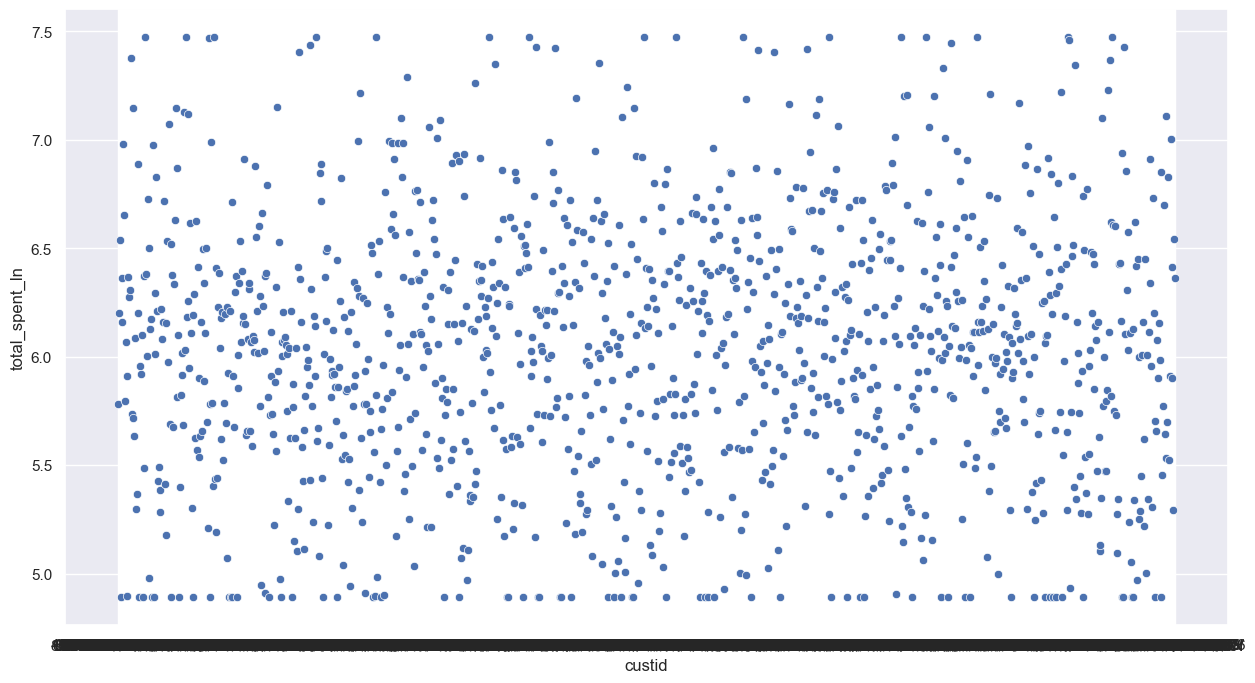

In [108]:
#plot for y test values
sns.scatterplot(y_test)

<Axes: >

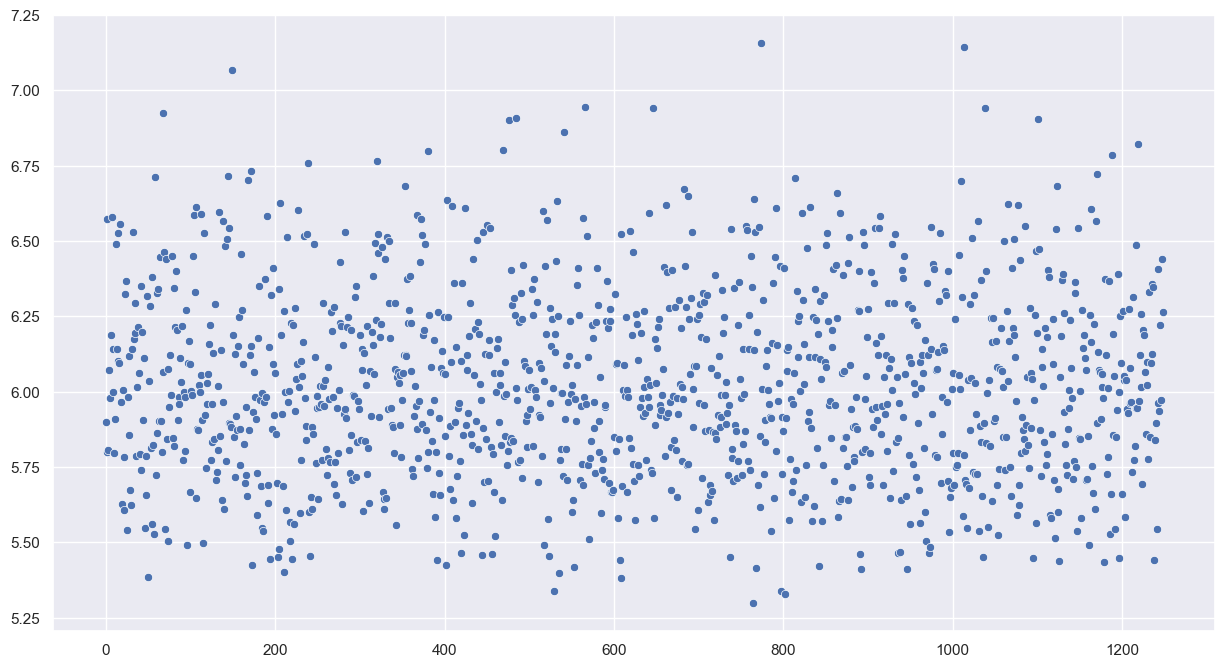

In [109]:
##plot for predicted values
sns.scatterplot(pred_lasso)

<Axes: ylabel='Density'>

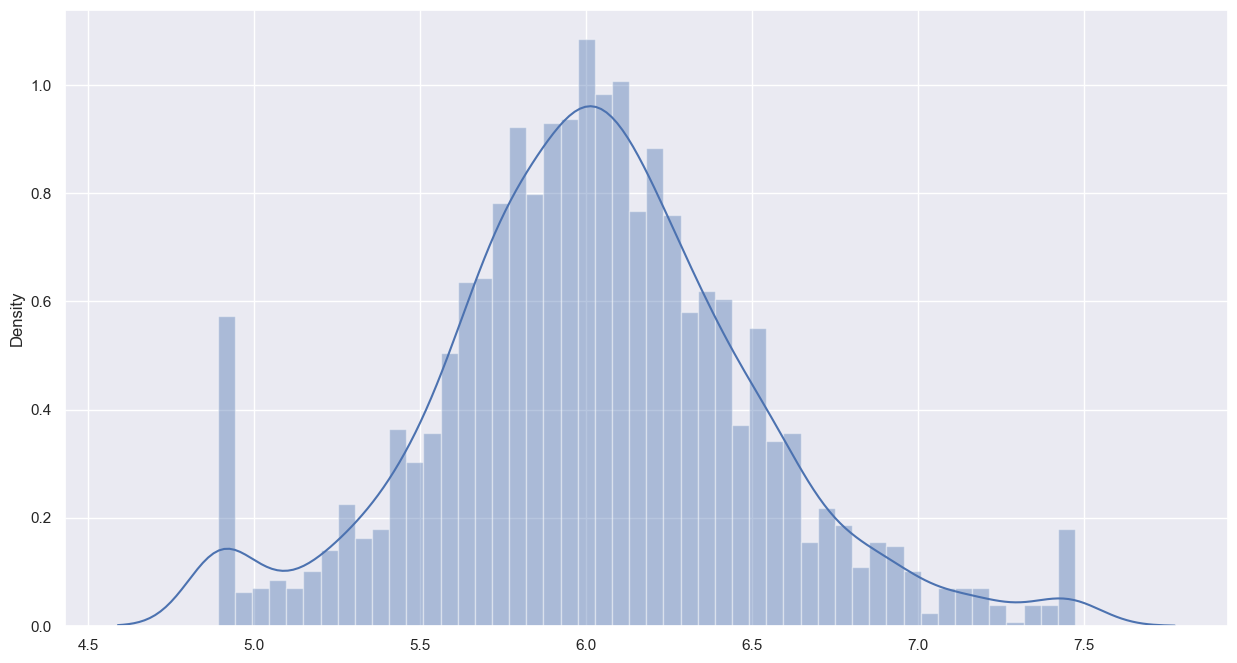

In [110]:
sns.distplot((y_test,pred_lasso),bins=50)

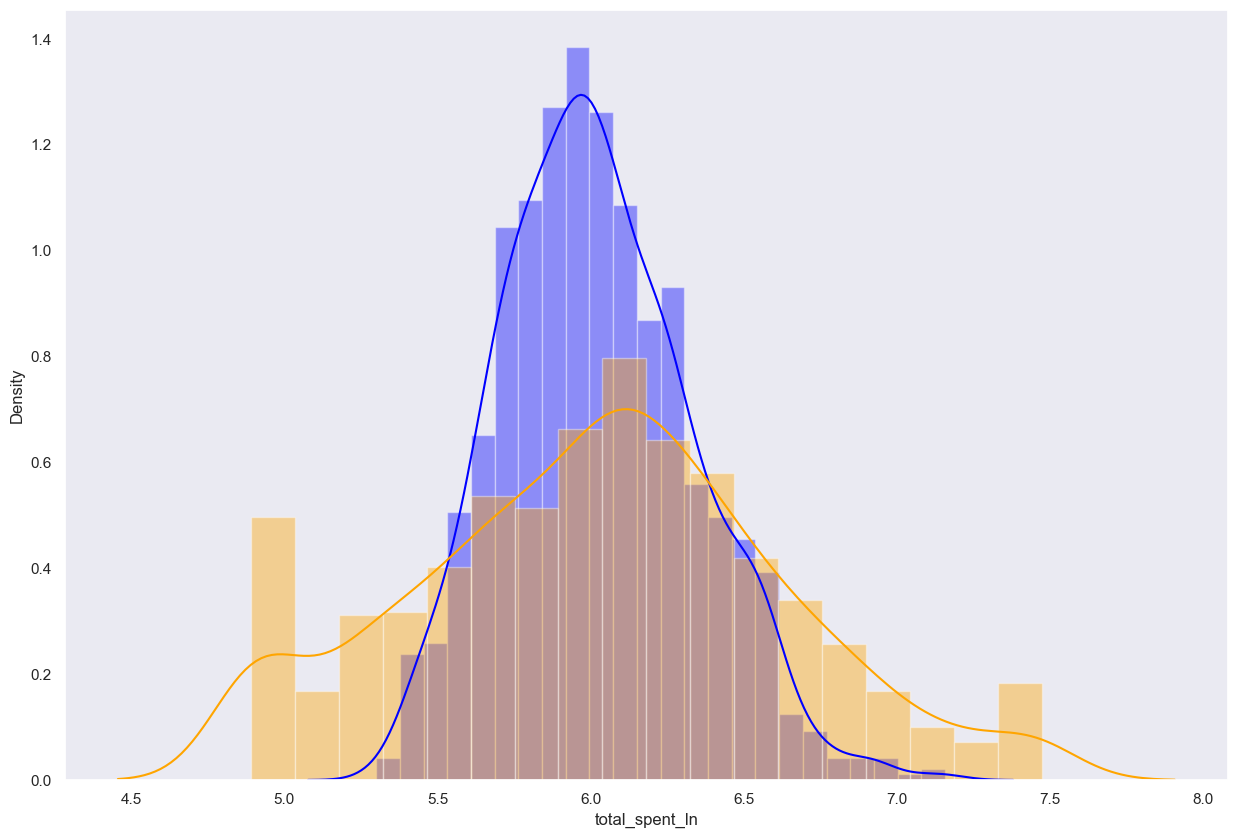

In [111]:
y_pred=lassoregcv.predict(X_test_std)
plt.figure(figsize=(15,10))
sns.distplot(y_pred,color="Blue")
sns.distplot(y_test,color="Orange")
plt.grid()
plt.show()

<Axes: xlabel='total_spent_ln', ylabel='Density'>

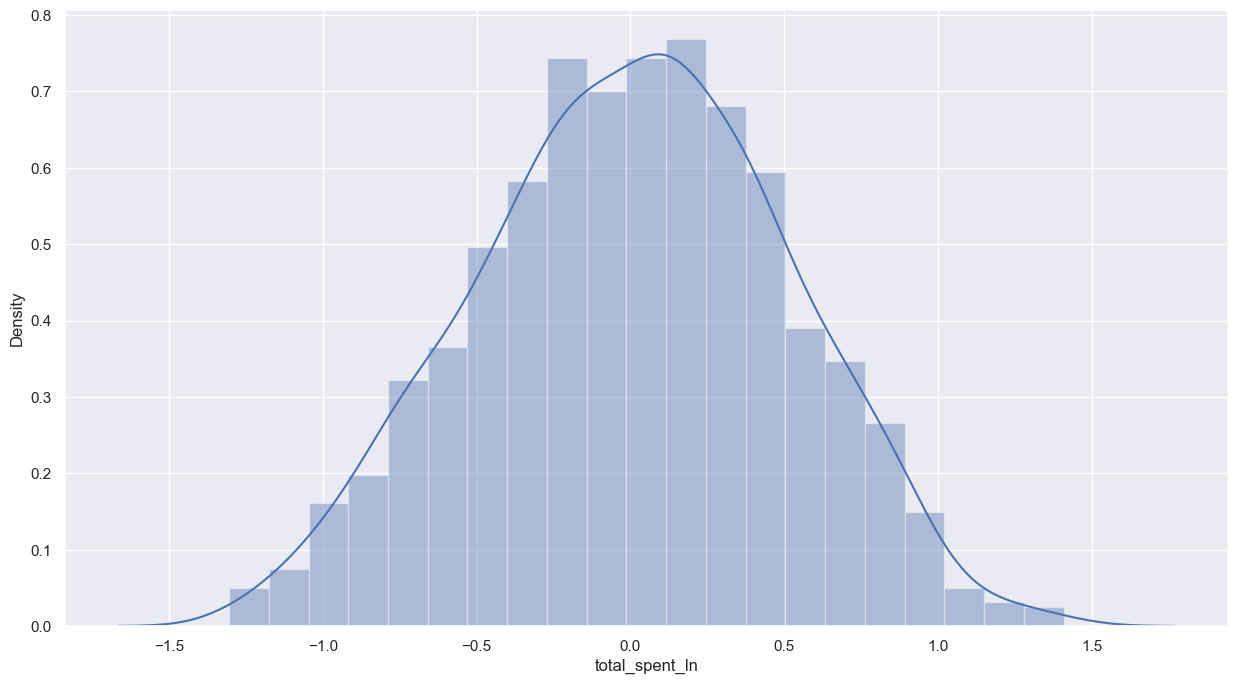

In [112]:
#Check Normality and Residuals
residuals=y_test - pred_lasso
sns.distplot(residuals)

<Axes: xlabel='custid', ylabel='total_spent_ln'>

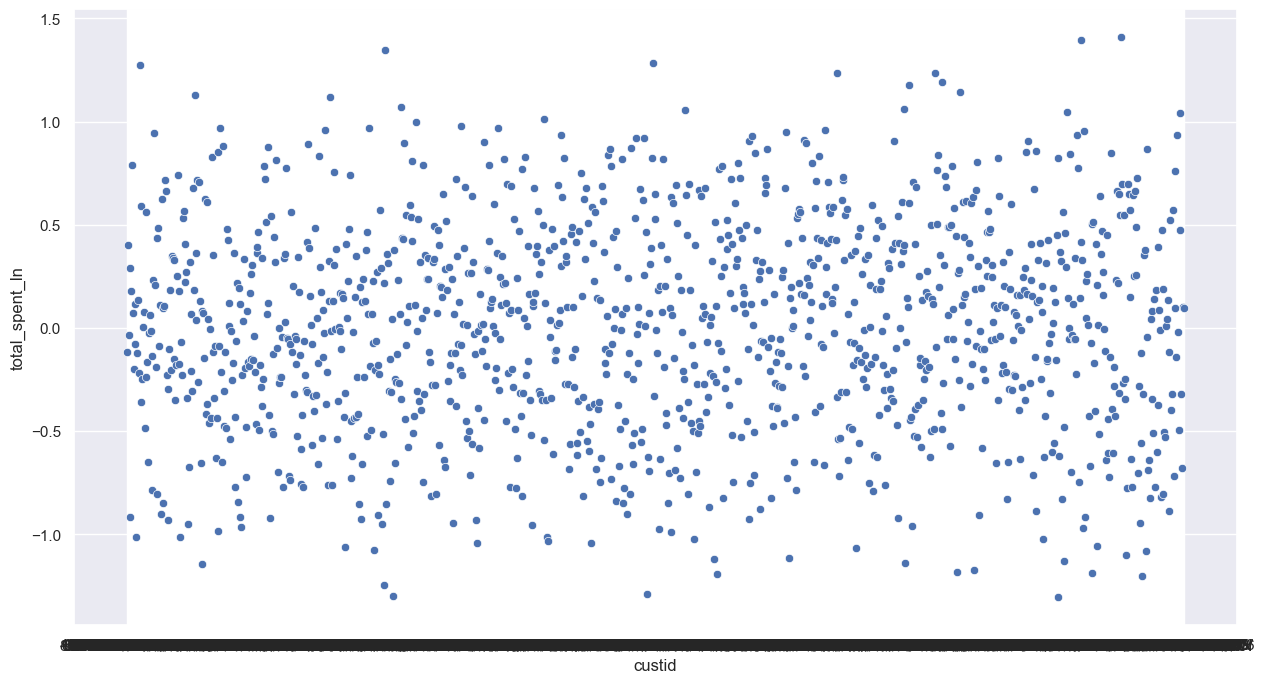

In [114]:
sns.scatterplot(residuals)

### Homoscedasticity

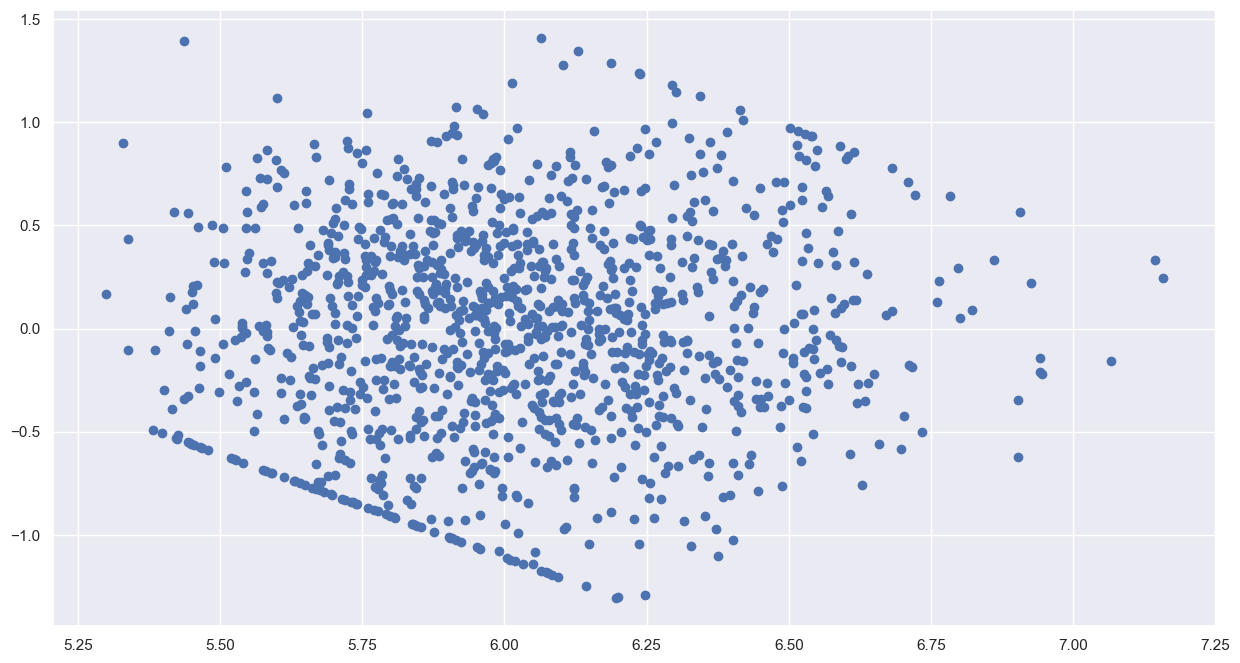

In [116]:
fig, ax = plt.subplots(figsize=(15,8))
_ = ax.scatter(y_pred, residuals)

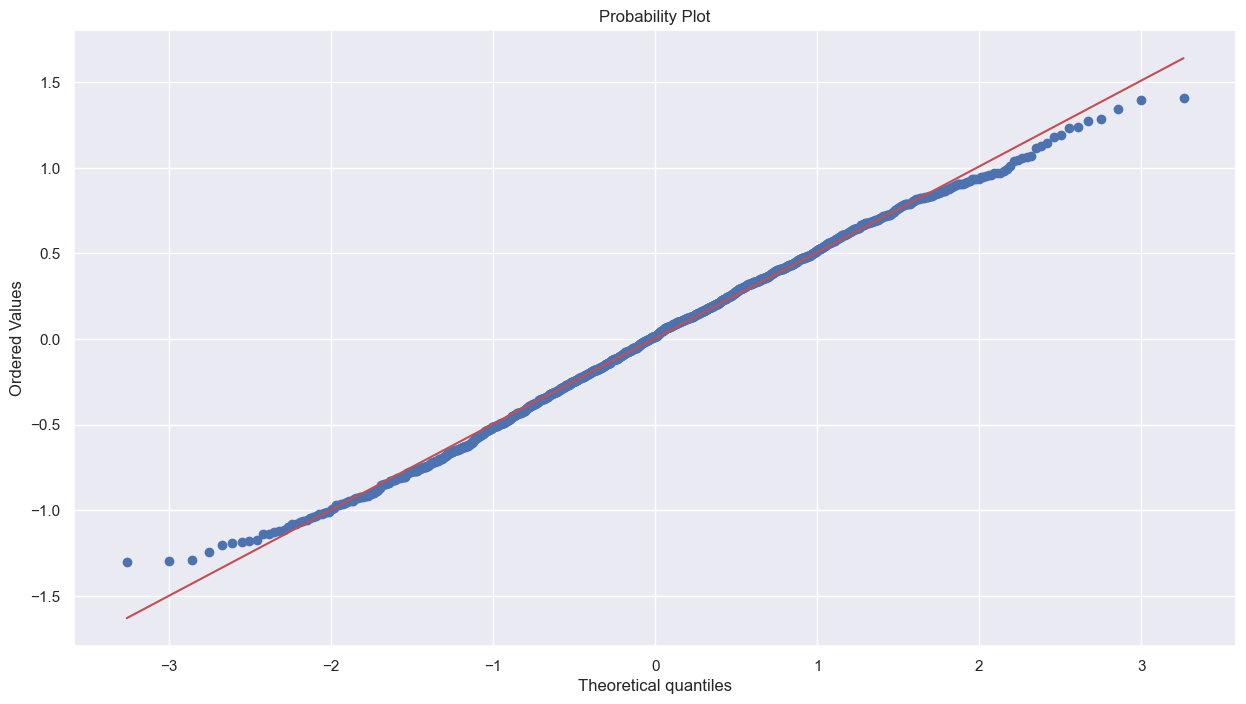

In [113]:
from scipy import stats
import pylab

stats.probplot(residuals,dist='norm',plot=pylab)
pylab.show()

In [118]:
# Expectation (mean) of residuals is zero
np.mean(residuals)

0.005107645583910471

### No Autocorrelation Of Residuals

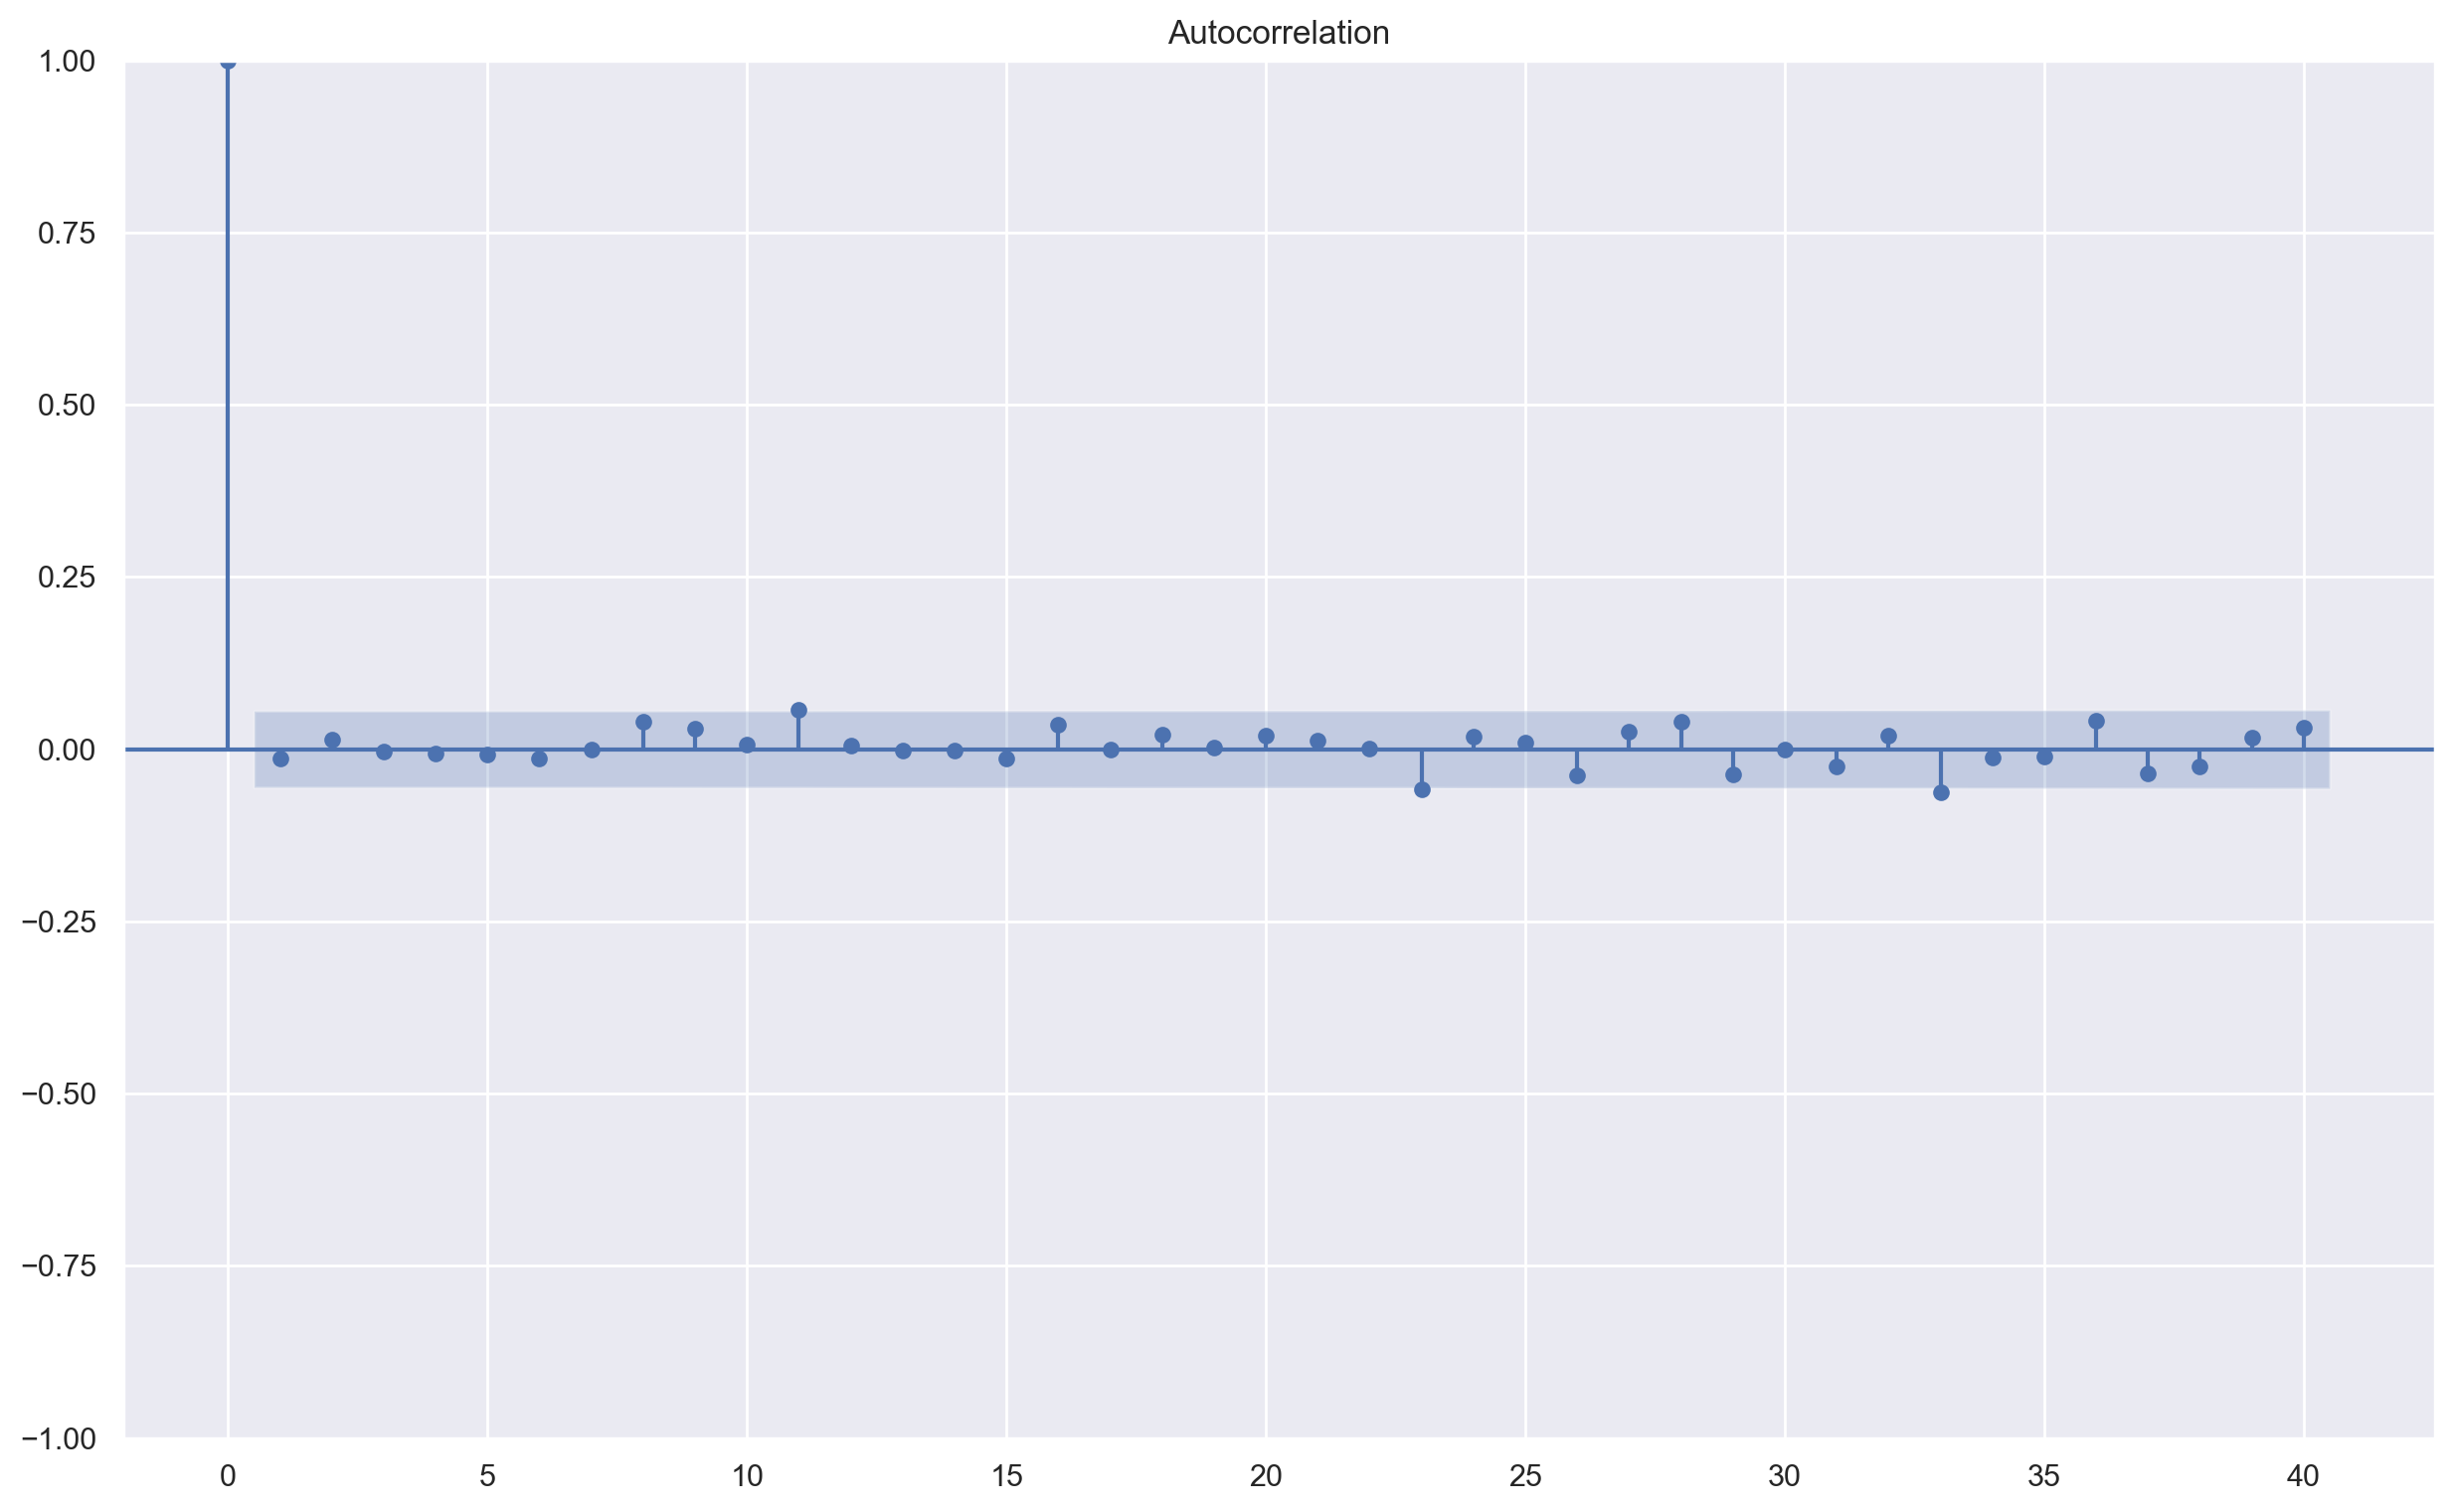

In [120]:
import statsmodels.tsa.api as smt
acf = smt.graphics.plot_acf(residuals, lags=40 , alpha=0.05)
acf.show()

* From the above histogram and Q-Q plot, shows that the residuals are normally distributed, so our assumption is not violate